# Sommaire

* [Chargement](#Chargement)
* [Encodage](#Encodage)
* [Selection de variables](#Selection-de-variables)
* [Train, test, split](#Train,-test,-split)
* [Preprocessing](#Preprocessing)
* [Modelisation](#Modelisation)
    * [Moyenne](#Moyenne)
    * [Comparatif des modèles](#Comparatif-des-modeles)
    * [Arbre de décision](#Arbre-de-decision)
    * [Random Forest](#Random-Forest)
    * [Ada Boost](#Ada-Boost)
    * [Gradient Boost](#Gradient-Boost)
    * [XGBoost](#XGBoost)
    * [Reseau de neurones](#Reseau-de-neurones)
        * [Monocouche](#Monocouche)
        * [2 couches](#2-couches)
* [Moteur](#Moteur)



In [1]:
import matplotlib as mplt
import pandas as pd
import seaborn as sns
sns.set(font='Franklin Gothic Book',rc={
 'axes.axisbelow': False,
 'axes.edgecolor': 'lightgrey',
 'axes.facecolor': 'None',
 'axes.grid': False,
 'axes.labelcolor': 'dimgrey',
 'axes.spines.right': False,
 'axes.spines.top': False,
 'figure.facecolor': 'white',
 'lines.solid_capstyle': 'round',
 'patch.edgecolor': 'w',
 'patch.force_edgecolor': True,
 'text.color': 'dimgrey',
 'xtick.bottom': False,
 'xtick.color': 'dimgrey',
 'xtick.direction': 'out',
 'xtick.top': False,
 'ytick.color': 'dimgrey',
 'ytick.direction': 'out',
 'ytick.left': False,
 'ytick.right': False})

# use the .set_context() method to fine-tune font size settings.
#sns.set_context("notebook", rc={"font.size":16,"axes.titlesize":16,"axes.labelsize":14})

mplt.font_manager._rebuild()

pd.set_option('display.min_rows', 30)
pd.options.display.float_format = '{:20,.2f}'.format #disable scientific notation

# Chargement

In [2]:
%run /Users/hui-guan/Documents/Developpement/Jupyter/Lib/outilsEDA.py


In [3]:
import pandas as pd
import time

start=time.time()
df=pd.read_csv("./flights_cleaned_2000.csv",sep=",")

In [4]:
df.dropna(inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 983527 entries, 0 to 1097759
Data columns (total 35 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   MONTH                  983527 non-null  int64  
 1   DAY_OF_MONTH           983527 non-null  int64  
 2   DAY_OF_WEEK            983527 non-null  int64  
 3   FL_DATE                983527 non-null  object 
 4   UNIQUE_CARRIER         983527 non-null  object 
 5   AIRLINE_ID             983527 non-null  float64
 6   CARRIER                983527 non-null  object 
 7   TAIL_NUM               983527 non-null  object 
 8   FL_NUM                 983527 non-null  float64
 9   ORIGIN_AIRPORT_SEQ_ID  983527 non-null  float64
 10  ORIGIN_CITY_NAME       983527 non-null  object 
 11  ORIGIN_WAC             983527 non-null  float64
 12  DEST_AIRPORT_SEQ_ID    983527 non-null  float64
 13  DEST_CITY_NAME         983527 non-null  object 
 14  DEST_WAC               983527 non-n

In [5]:
# on regarde s'il y a une correspondance entre la compagnie aerienne et l'airline_id
df['AIRLINE_ID'].unique(),df['CARRIER'].unique(),df[['AIRLINE_ID','CARRIER']].sample(20)

(array([19805., 19930., 20409., 19790., 20436., 19690., 20416., 20366.,
        20304., 19977., 21171., 19393.]),
 array(['AA', 'AS', 'B6', 'DL', 'F9', 'HA', 'NK', 'EV', 'OO', 'UA', 'VX',
        'WN'], dtype=object),
                   AIRLINE_ID CARRIER
 930935             20,304.00      OO
 482471             19,805.00      AA
 473356             19,805.00      AA
 640351             19,393.00      WN
 615404             19,393.00      WN
 543993             19,790.00      DL
 975352             19,977.00      UA
 81054              19,930.00      AS
 926864             20,304.00      OO
 780378             20,366.00      EV
 732630             19,790.00      DL
 1026428            19,805.00      AA
 785115             20,436.00      F9
 907700             19,690.00      HA
 138571             20,304.00      OO
 711167             19,805.00      AA
 481940             19,805.00      AA
 890760             19,393.00      WN
 647123             19,393.00      WN
 662608             19

On constate que chaque AIRLINE_ID correspond à une compagnie (CARRIER)
Pour la suite de l'étude nous garderons le CARRIER (encodé)

## Encodage

In [6]:
import copy

# copie par valeur
dfQuantitative=copy.deepcopy(df.select_dtypes(include=["datetime","number","bool","float64"]))
dfQualitative=copy.deepcopy(df.select_dtypes(exclude=["datetime","number","bool","float64"]))

X_categorical_columns=['CARRIER','ORIGIN_CITY_NAME','DEST_CITY_NAME']
#Encodage binaire sur la compagnie, la ville d'origine et la ville de destination
dummies = pd.get_dummies(dfQualitative[X_categorical_columns], columns=X_categorical_columns, drop_first=True)

In [7]:
X=dfQuantitative.loc[:, (dfQuantitative.columns != 'ARR_DELAY') & (dfQuantitative.columns != 'ARR_DELAY_NEW')]
y=dfQuantitative[['ARR_DELAY']]

array([[<AxesSubplot:title={'center':'ARR_DELAY'}>]], dtype=object)

findfont: Font family ['Franklin Gothic Book'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Franklin Gothic Book'] not found. Falling back to DejaVu Sans.


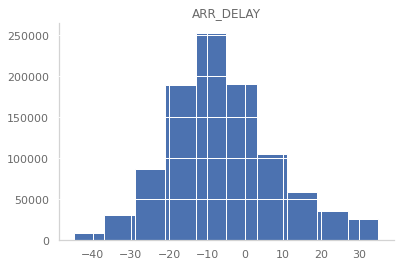

In [8]:
y.hist()

La distribution de la variable ARR_DELAY est proche de la normale.

In [9]:
# filtre sur les données NA
maskNotNA=(y.notna().values==True)

In [10]:
X=X[maskNotNA]
y=y[maskNotNA]
dummies=dummies[maskNotNA]

In [11]:
# ajout des catégories encodées (dummies)
X=pd.concat([X,dummies],axis=1)

In [12]:
X.shape, y.shape

((983527, 191), (983527, 1))

In [13]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 983527 entries, 0 to 1097759
Columns: 191 entries, MONTH to DEST_CITY_NAME_West Palm Beach/Palm Beach, FL
dtypes: float64(22), int64(6), uint8(163)
memory usage: 370.5 MB


# Selection de variables

On choisit de garder seulement les variables connues avant décollage pour eviter le data leakage:  
* ville de départ/destination
* heure/jour/mois de départ
* vol court/moyen/long courrier
* distance
* compagnie

Note: on a constaté que les variables CRS_ARR_TIME (heure arrivée) et CRS_ELAPSED_TIME (durée) fluctuent pour des vols sur des origines/destinations identiques -> on ne les gardera pas pour limiter le "bruit" dans la modélisation.

In [14]:
cityNames=(X.filter(regex='_CITY_NAME*').columns).tolist()

In [15]:
X.sample(15)

,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,AIRLINE_ID,FL_NUM,ORIGIN_AIRPORT_SEQ_ID,ORIGIN_WAC,DEST_AIRPORT_SEQ_ID,DEST_WAC,CRS_DEP_TIME,...,"DEST_CITY_NAME_San Juan, PR","DEST_CITY_NAME_Santa Ana, CA","DEST_CITY_NAME_Seattle, WA","DEST_CITY_NAME_Spokane, WA","DEST_CITY_NAME_St. Louis, MO","DEST_CITY_NAME_Tampa, FL","DEST_CITY_NAME_Tucson, AZ","DEST_CITY_NAME_Tulsa, OK","DEST_CITY_NAME_Washington, DC","DEST_CITY_NAME_West Palm Beach/Palm Beach, FL"
641978,2,10,3,"19,393.00","2,296.00","1,389,101.00",91.00,"1,379,604.00",91.00,700.00,...,0,0,0,0,0,0,0,0,0,0
1079924,3,16,3,"20,409.00","1,951.00","1,072,102.00",13.00,"1,320,402.00",33.00,"1,113.00",...,0,0,0,0,0,0,0,0,0,0
686551,2,24,3,"19,393.00",756.00,"1,463,502.00",33.00,"1,106,603.00",44.00,"1,155.00",...,0,0,0,0,0,0,0,0,0,0
320492,1,17,7,"19,393.00","2,908.00","1,289,203.00",91.00,"1,537,602.00",81.00,"1,125.00",...,0,0,0,0,0,0,1,0,0,0
679557,2,22,1,"19,393.00",962.00,"1,082,104.00",35.00,"1,169,704.00",33.00,"1,805.00",...,0,0,0,0,0,0,0,0,0,0
151800,1,27,3,"19,977.00","1,710.00","1,477,102.00",91.00,"1,104,203.00",44.00,"1,322.00",...,0,0,0,0,0,0,0,0,0,0
264871,1,2,6,"19,393.00",430.00,"1,288,903.00",85.00,"1,385,103.00",73.00,"2,120.00",...,0,0,0,0,0,0,0,0,0,0
93702,1,19,2,"20,409.00","1,015.00","1,245,102.00",33.00,"1,169,704.00",33.00,700.00,...,0,0,0,0,0,0,0,0,0,0
135232,1,16,6,"20,304.00","6,510.00","1,288,903.00",85.00,"1,289,203.00",91.00,"1,154.00",...,0,0,0,0,0,0,0,0,0,0
345423,1,27,3,"19,393.00","1,011.00","1,295,302.00",22.00,"1,233,904.00",42.00,"1,135.00",...,0,0,0,0,0,0,0,0,0,0


In [16]:
# colonnes que l'on garde pour la modelisation
cols=[
     'DAY_OF_MONTH',
     'MONTH',
     'CRS_DEP_TIME',
#     'CRS_ARR_TIME', 
     'SHORT_FLIGHT',
     'MEDIUM_FLIGHT',
     'LONG_FLIGHT',
     'DISTANCE',
#     'CRS_ELAPSED_TIME',
     'CARRIER_AS',
     'CARRIER_B6',
     'CARRIER_DL',
     'CARRIER_EV',
     'CARRIER_F9',
     'CARRIER_HA',
     'CARRIER_NK',
     'CARRIER_OO',
     'CARRIER_UA',
     'CARRIER_VX',
     'CARRIER_WN'
]+cityNames
X=X[cols]

In [17]:
X.sample(15)

,DAY_OF_MONTH,MONTH,CRS_DEP_TIME,SHORT_FLIGHT,MEDIUM_FLIGHT,LONG_FLIGHT,DISTANCE,CARRIER_AS,CARRIER_B6,CARRIER_DL,...,"DEST_CITY_NAME_San Juan, PR","DEST_CITY_NAME_Santa Ana, CA","DEST_CITY_NAME_Seattle, WA","DEST_CITY_NAME_Spokane, WA","DEST_CITY_NAME_St. Louis, MO","DEST_CITY_NAME_Tampa, FL","DEST_CITY_NAME_Tucson, AZ","DEST_CITY_NAME_Tulsa, OK","DEST_CITY_NAME_Washington, DC","DEST_CITY_NAME_West Palm Beach/Palm Beach, FL"
436568,2,2,650.00,0,1,0,416.00,0,0,0,...,0,0,0,0,0,0,0,0,0,0
463228,29,2,"1,336.00",0,1,0,551.00,0,0,0,...,0,0,0,0,0,0,0,0,0,0
818474,8,3,805.00,1,0,0,308.00,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1088144,6,3,"1,740.00",0,1,0,"1,670.00",0,0,0,...,0,0,0,0,0,0,0,0,0,0
783022,3,3,"1,020.00",1,0,0,95.00,0,0,0,...,0,0,0,0,0,0,0,0,0,0
752273,22,3,"1,835.00",0,1,0,983.00,0,0,1,...,0,0,0,0,0,0,0,0,0,0
688461,24,2,"1,140.00",0,1,0,949.00,0,0,0,...,0,0,0,0,0,0,0,0,1,0
745164,20,3,"1,257.00",0,1,0,425.00,0,0,1,...,0,0,0,0,0,0,0,0,0,0
796298,2,3,"1,810.00",1,0,0,237.00,0,0,0,...,0,0,0,0,1,0,0,0,0,0
184364,15,1,"1,520.00",1,0,0,236.00,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [18]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 983527 entries, 0 to 1097759
Columns: 170 entries, DAY_OF_MONTH to DEST_CITY_NAME_West Palm Beach/Palm Beach, FL
dtypes: float64(2), int64(5), uint8(163)
memory usage: 212.9 MB


# Train, test, split

In [20]:
# separation du jeu de donnée d'entrainement, et de test
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test=train_test_split(X,y,test_size=0.3,random_state = 49)
X_train.shape, X_test.shape , y_train.shape, y_test.shape

((688468, 170), (295059, 170), (688468, 1), (295059, 1))

# Preprocessing

## Standardisation

In [21]:
# standardiser les données (centré reduit)
from sklearn import preprocessing
robust_scale=preprocessing.RobustScaler().fit(X_train) # moins sensible aux valeurs aberrantes

#X_train_std = std_scale.transform(X_train)
X_train_std = robust_scale.transform(X_train)
X_test_std = robust_scale.transform(X_test)

# Modelisation

Les mesures de score:
* R2 : indique dans quelle mesure une mesure independante explique la variance de la variable dépendante
* MSE : plus rapide à calculer que le RMSE et pas de mise à l'echelle
* RMSE : Par rapport à MAE, le RMSE ne traite pas chaque erreur de la même manière. Il donne plus d'importance aux erreurs les plus significatives. Cela signifie qu'une grosse erreur suffit pour obtenir un très mauvais RMSE
* MAE: cette mesure donne moins de poids aux valeurs aberrantes

on excluera donc la MAE de nos mesures, et on gardera le MSE qui est plus rapide à calculer, car la mise à l'échelle n'est pas indispensable pour la recherche de modele

In [22]:
#%%writefile /Users/hui-guan/Documents/Developpement/Jupyter/Lib/outilsModelisation.py
#%load/Users/hui-guan/Documents/Developpement/Jupyter/Lib/outilsModelisation.py

from sklearn.metrics import r2_score, mean_squared_error

def scoresModele(nomModele,modele,X_train,y_train):
    debut = time.time()

    model=modele
    
    # Entraîner le modèle sur le jeu d'entraînement
    model.fit(X_train,y_train)
    
    # Predire avec le modèle
    arr_y_pred=model.predict(X_train)
    y_pred=pd.DataFrame(arr_y_pred) # conversion du tableau résultat en Dataframe
    
    fin =time.time() # durée du calcul
    
    # Evaluer les scores
    r2 = r2_score(y_train, y_pred)
    mse=mean_squared_error(y_train,y_pred)
#    rmse=sqrt(mse)
#    mae=mean_absolute_error(y_train,y_pred)
    
    # Synthetiser les resultats
    resultats = pd.DataFrame({
    'Modèle' : [nomModele],
#    'MAE':[mae],
    'R2' : [r2],
    'MSE' : [mse],
#    'RMSE' : [rmse],
    'Durée' : [fin-debut]})
    
    return resultats

# R2 score sur tensorflow
import tensorflow as tf

def r2_score_tf(y_true, y_pred):
    SS_tot = tf.reduce_sum(tf.square(y_true - tf.reduce_mean(y_true))) 
    SS_res = tf.reduce_sum(tf.square(y_true - y_pred))     
    return ( 1 - tf.divide(SS_res,SS_tot) )

## Moyenne - Baseline

In [25]:
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np

debut = time.time()

nomModele="Moyenne"

# Predire avec la moyenne
meanValue=y_train.mean().values
arr_y_pred=np.repeat(meanValue,len(y_train.index)) # tableau d'observations valant toutes la moyenne de y_train

y_pred=pd.DataFrame(arr_y_pred)

fin =time.time()
y_pred

# Evaluer les scores
r2 = r2_score(y_train, y_pred)
mse=mean_squared_error(y_train,y_pred)
 
## Synthetiser les resultats
resultats = pd.DataFrame({
'Modèle' : [nomModele],
'R2' : [r2],
'MSE' : [mse],
'Durée' : [fin-debut]})

resultats

,Modèle,R2,MSE,Durée
0,Moyenne,0.00,203.33,0.01


Le score R2 en utilisant la moyenne comme modele de prediction ne predit pas mieux qu'une ligne horizontale

# Comparatif des modeles

In [26]:
%%time

import joblib
from sklearn.linear_model import ElasticNet, Lasso, Ridge, LinearRegression
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor, AdaBoostRegressor,RandomForestRegressor

resultats=pd.DataFrame()

models = {"Régression Linéaire": LinearRegression(),
          "Régression Ridge": Ridge(alpha=8),
          "Régression Lasso": Lasso(alpha=1),
          "Régression ElasticNet": ElasticNet(alpha=1),
          "Arbre de décision": DecisionTreeRegressor(random_state=34),
          "Random Forest": RandomForestRegressor(random_state=72,max_depth=30,n_estimators=100,n_jobs=-1),
          "Ada Boost":AdaBoostRegressor(base_estimator=DecisionTreeRegressor(random_state=72,max_depth=1),loss='linear',learning_rate=0.5,n_estimators=50),
          "Gradient Boost":GradientBoostingRegressor(loss='ls',learning_rate=0.3,n_estimators=200,subsample=0.8,criterion='mse'),
          "XGBoost": XGBRegressor(n_estimators=200, max_depth=4, eta=0.1, subsample=0.7, colsample_bytree=0.6)
         }

for nomModele in models:
    model=models[nomModele]
    res=scoresModele(nomModele,model,X_train_std,y_train)
    resultats=pd.concat([resultats,res])    
    
joblib.dump(resultats,"resultats.jbl.bz2")

resultats.sort_values(by="R2",ascending=False)

<ipython-input-23-6e204e4a2d59>:12: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train,y_train)
/Users/hui-guan/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/hui-guan/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


CPU times: user 2h 17min 55s, sys: 1min 10s, total: 2h 19min 6s
Wall time: 22min 52s


,Modèle,R2,MSE,Durée
0,Arbre de décision,1.00,0.01,28.18
0,Random Forest,0.62,77.40,603.80
0,Gradient Boost,0.13,177.63,431.68
0,XGBoost,0.12,179.87,94.61
0,Régression Linéaire,0.08,187.64,5.19
0,Régression Ridge,0.08,187.65,1.04
0,Régression ElasticNet,0.01,202.15,1.80
0,Régression Lasso,0.00,203.02,1.73
0,Ada Boost,0.00,203.23,204.24


Text(0.5, 1.0, 'Comparaison des performances R2 des modèles (jeu d entrainement)')

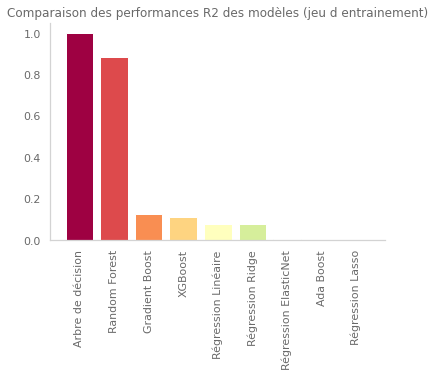

In [31]:
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np

#colors = cm.Spectral(resultats['R2'].values)
colors=cm.Spectral(np.linspace(0,1,len(resultats['R2'].values)))
y=resultats["R2"].sort_values(ascending=False)
x=resultats[["Modèle","R2"]].sort_values(by='R2',ascending=False)['Modèle']
plt.bar(x,y,color=colors)
plt.xticks(rotation=90);
plt.title("Comparaison des performances R2 des modèles (jeu d entrainement)")


Text(0.5, 1.0, 'Comparaison des performances MSE des modèles (jeu d entrainement)')

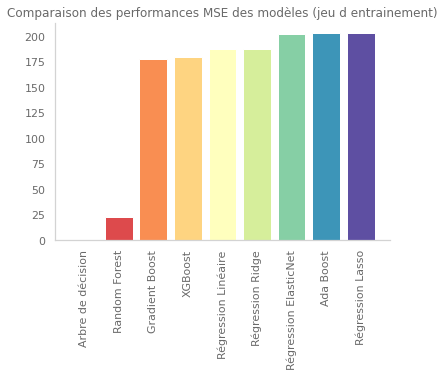

In [32]:
from matplotlib import cm
import numpy as np

#colors = cm.Spectral(resultats['R2'].values)
colors=cm.Spectral(np.linspace(0,1,len(resultats['MSE'].values)))
y=resultats["MSE"].sort_values(ascending=True)
x=resultats[["Modèle","MSE"]].sort_values(by='MSE',ascending=True)['Modèle']
plt.bar(x,y,color=colors)
plt.xticks(rotation=90);
plt.title("Comparaison des performances MSE des modèles (jeu d entrainement)")


## Arbre de decision 

In [97]:
from sklearn.tree import DecisionTreeRegressor

regressionTree=DecisionTreeRegressor(random_state=0)

scoresModele("Arbre de décision",regressionTree,X_train_std,y_train)

,Modèle,R2,MSE,Durée
0,Arbre de décision,1.00,0.01,30.70


R2=1 : Les valeurs prédites correspondent exactement aux valeurs observées dans le jeu d'entrainement.
Verifions les predictions avec le jeu de test qu'il n'y a pas de surapprentissage.

### Recherche des meilleurs parametres

In [25]:
%%time
# Recherche du meilleur parametre par Grid search et validation croisée
# Compte tenu des temps de calcul, j'ai figé les paramètres pour faire seulement de la validation croisée et confirmer les scores
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import DecisionTreeRegressor
params = {'max_depth': [10,30],
          'min_samples_split':[2,10]}

scorers = ['neg_mean_squared_error','r2']

grid = RandomizedSearchCV(estimator=DecisionTreeRegressor(random_state=42), # optimisation du grid search par echantillonnage
                              param_distributions=params, 
                              n_iter=1,
                              verbose=5, 
                              cv=3, 
                              scoring=scorers,
                              refit='neg_mean_squared_error')

grid = grid.fit(X_train_std, y_train) 
print(f"Best score :{grid.best_score_} - Parameters used:{grid.best_params_}")

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END max_depth=30, min_samples_split=2; neg_mean_squared_error: (test=-248.060) r2: (test=-0.217) total time=  27.0s
[CV 2/3] END max_depth=30, min_samples_split=2; neg_mean_squared_error: (test=-247.414) r2: (test=-0.212) total time=  27.8s
[CV 3/3] END max_depth=30, min_samples_split=2; neg_mean_squared_error: (test=-248.145) r2: (test=-0.228) total time=  27.5s
Best score :-247.8728039249635 - Parameters used:{'min_samples_split': 2, 'max_depth': 30}
CPU times: user 1min 45s, sys: 1.35 s, total: 1min 46s
Wall time: 1min 46s


On constate sur la recherche de meilleurs hyperparamètre que le R2 est devenu négatif.

findfont: Font family ['Franklin Gothic Book'] not found. Falling back to DejaVu Sans.


[Text(837.0, 1514.3142857142857, 'CRS_ELAPSED_TIME <= -0.412\nmse = 198.968\nsamples = 845039\nvalue = -6.589'),
 Text(418.5, 1281.3428571428572, 'CARRIER_WN <= 0.5\nmse = 150.146\nsamples = 227444\nvalue = -4.267'),
 Text(209.25, 1048.3714285714286, 'CARRIER_HA <= 0.5\nmse = 157.599\nsamples = 155864\nvalue = -5.199'),
 Text(104.625, 815.4, 'DISTANCE <= -0.496\nmse = 162.815\nsamples = 145639\nvalue = -5.464'),
 Text(52.3125, 582.4285714285713, 'CRS_ELAPSED_TIME <= -0.555\nmse = 165.461\nsamples = 113690\nvalue = -5.953'),
 Text(26.15625, 349.4571428571428, 'DEST_CITY_NAME_Houston, TX <= 0.5\nmse = 157.199\nsamples = 85546\nvalue = -5.356'),
 Text(13.078125, 116.48571428571427, '\n  (...)  \n'),
 Text(39.234375, 116.48571428571427, '\n  (...)  \n'),
 Text(78.46875, 349.4571428571428, 'DISTANCE <= -0.514\nmse = 186.196\nsamples = 28144\nvalue = -7.768'),
 Text(65.390625, 116.48571428571427, '\n  (...)  \n'),
 Text(91.546875, 116.48571428571427, '\n  (...)  \n'),
 Text(156.9375, 582.428

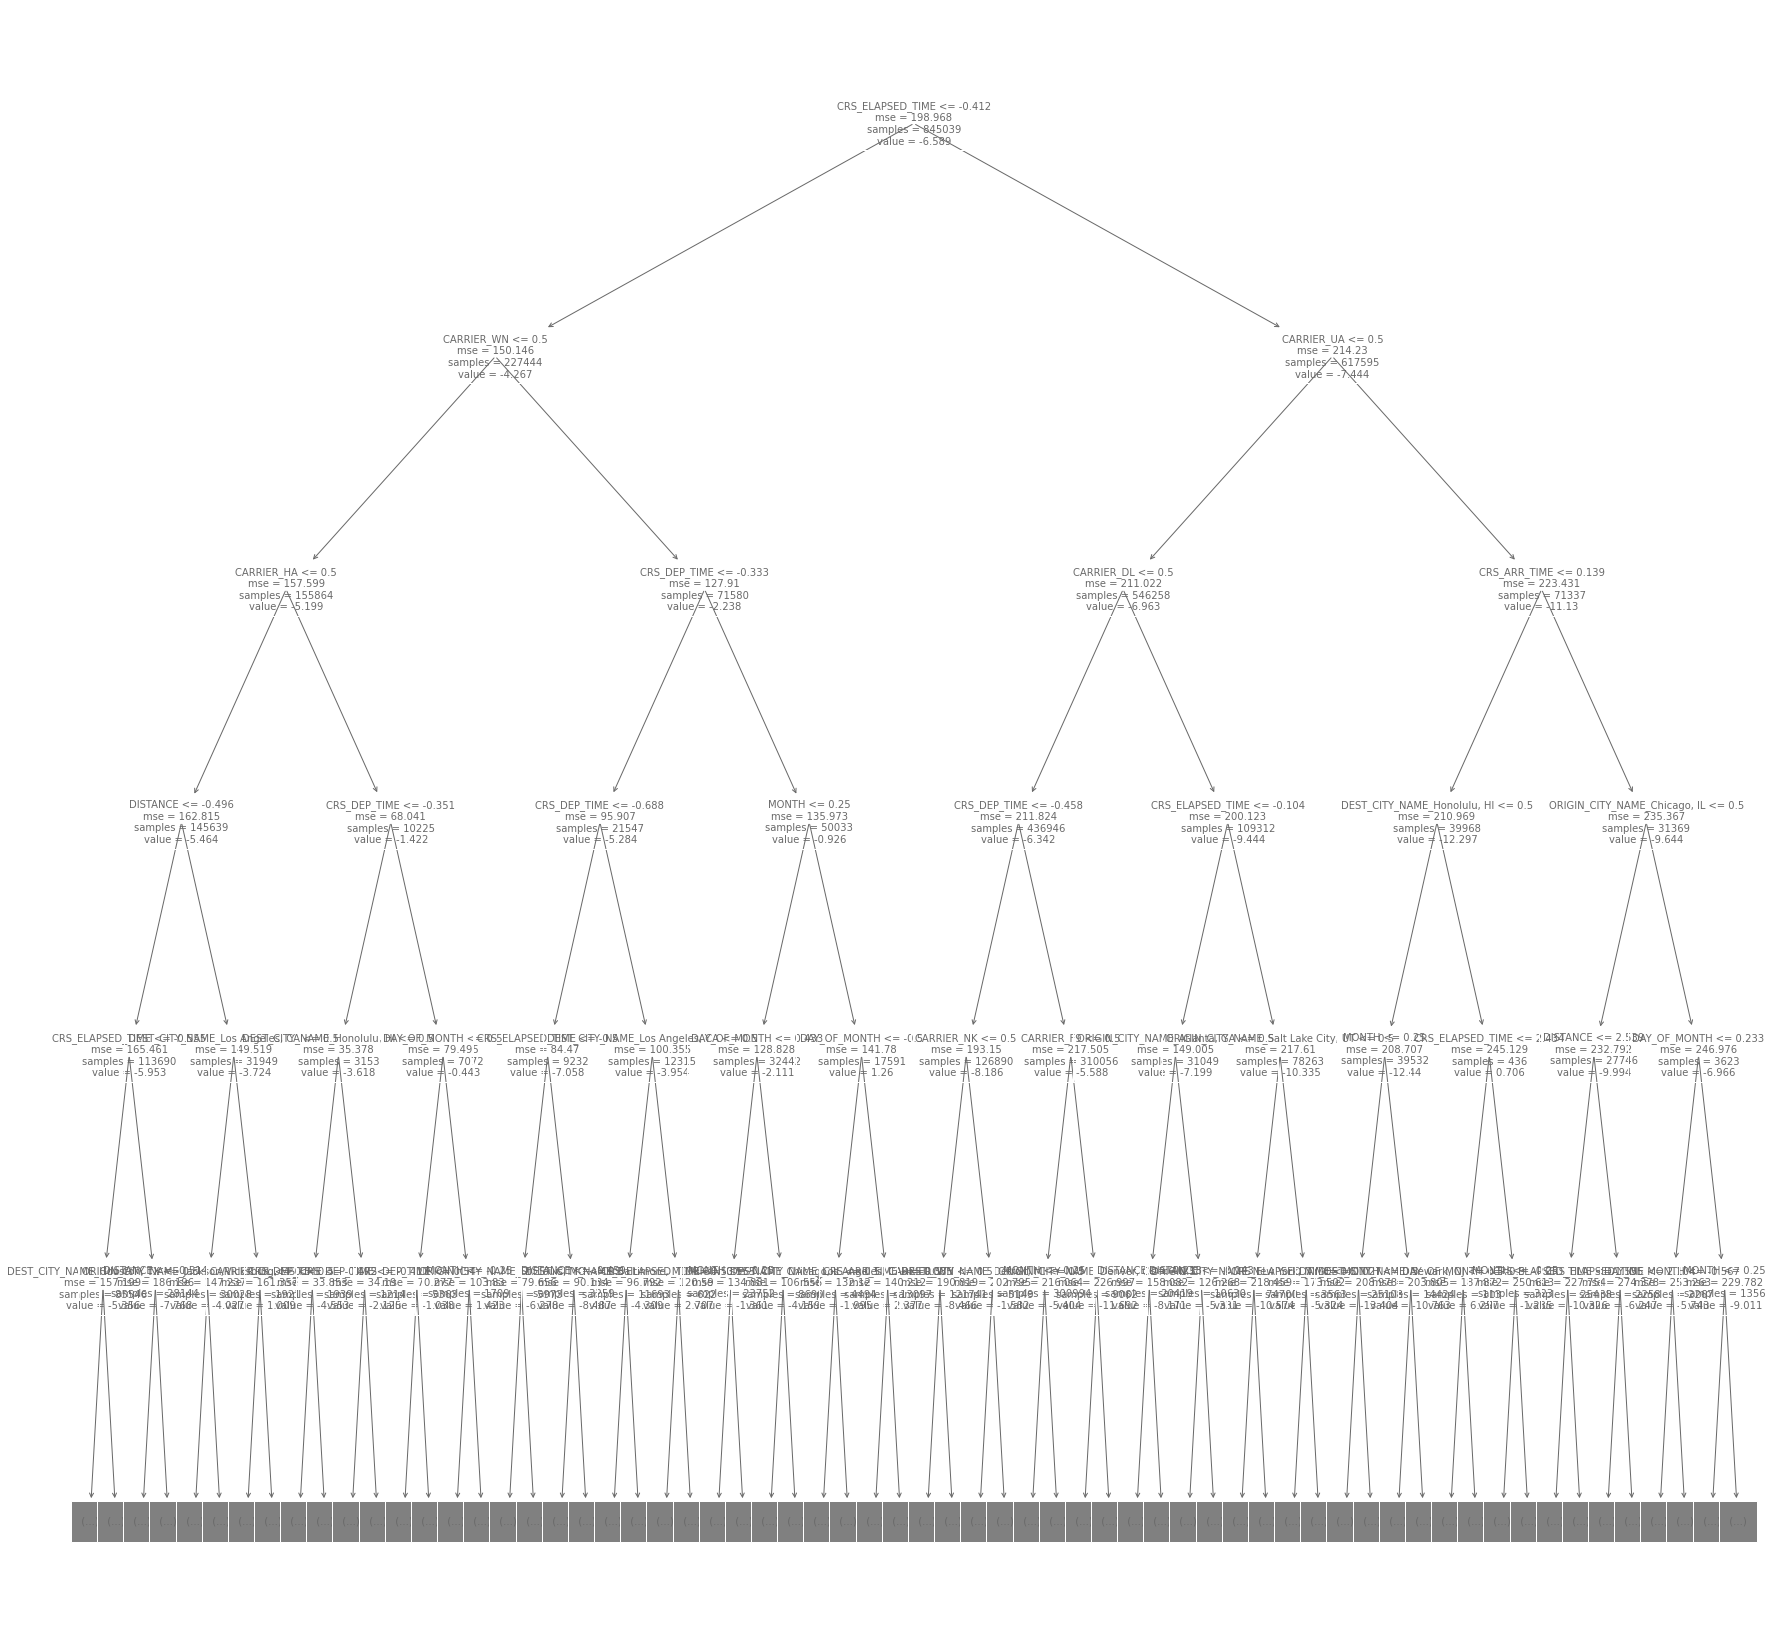

In [36]:
#visualisation de l'arbre de decision (une partie)
from sklearn import tree
import matplotlib.pyplot as plt
plt.figure(figsize=(30,30))
tree.plot_tree(regressionTree,max_depth=5,fontsize=10,feature_names=X.columns,filled=True) # on limite la profondeur a 5 pour réduire les temps de calcul

In [26]:
coefficients = abs(grid.best_estimator_.feature_importances_)
liste_coefs = pd.concat((pd.DataFrame(X.columns, columns = ['Variable']), 
                      pd.DataFrame(coefficients, columns = ['Coefficient'])), axis = 1).sort_values(by='Coefficient', ascending = False)

In [27]:
liste_coefs.head(10)

,Variable,Coefficient
0,DAY_OF_MONTH,0.32
2,CRS_DEP_TIME,0.20
6,DISTANCE,0.10
1,MONTH,0.06
15,CARRIER_UA,0.02
9,CARRIER_DL,0.01
17,CARRIER_WN,0.01
129,"DEST_CITY_NAME_Los Angeles, CA",0.01
106,"DEST_CITY_NAME_Chicago, IL",0.01
13,CARRIER_NK,0.01


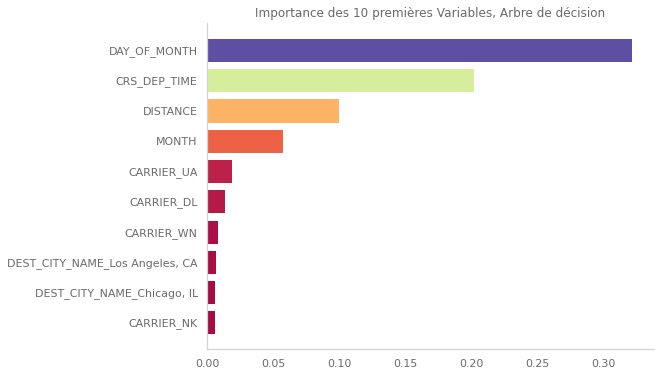

In [30]:
import matplotlib.pyplot as plt
from matplotlib import cm
colors = cm.Spectral(liste_coefs['Coefficient'].head(10) / float(max(liste_coefs['Coefficient'].head(10))))

plt.figure(figsize=(8,6))
plt.title('Importance des 10 premières Variables, Arbre de décision')
plt.barh(liste_coefs['Variable'].head(10),liste_coefs['Coefficient'].head(10),color=colors)
plt.gca().invert_yaxis()

### Arbre de décision optimisé

In [29]:
%%time
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_validate

# Cross validation
dt2 = DecisionTreeRegressor(max_depth = 30,
                           min_samples_split = 2) # valeur par rapport au résultat de la grid_search

scoring = ['r2', 'neg_mean_squared_error']
scores = cross_validate(dt2, X_train_std, y_train, cv=5,
                        scoring=scoring, return_train_score=False)
# report performance
pd.DataFrame(scores).T

CPU times: user 2min 49s, sys: 2.02 s, total: 2min 51s
Wall time: 2min 52s


,0,1,2,3,4
fit_time,34.73,34.45,35.22,33.70,33.34
score_time,0.10,0.11,0.11,0.11,0.10
test_r2,-0.20,-0.20,-0.18,-0.18,-0.20
test_neg_mean_squared_error,-244.49,-243.45,-241.96,-239.07,-243.97


La validation croisée confirme les mauvais score R2 et de MSE.

In [31]:
%%time
# verification sur les données de test
from sklearn.tree import DecisionTreeRegressor

regressionTree=DecisionTreeRegressor(max_depth = 30,min_samples_split = 2)
model=regressionTree.fit(X_train_std,y_train)
y_pred_train=model.predict(X_train_std)
r2_train = r2_score(y_train, y_pred_train)

y_pred_test=model.predict(X_test_std)
# Evaluer les scores
r2_test = r2_score(y_test, y_pred_test)
mse=mean_squared_error(y_test,y_pred_test)
r2_train,r2_test,mse

CPU times: user 25.5 s, sys: 354 ms, total: 25.9 s
Wall time: 25.9 s


(0.6139406582632774, -0.16443418869838577, 237.5223473594296)

En prediction sur le jeu de test, on trouve un R2 et un MSE très mauvais: on constate un fort surapprentissage du modele

## Random Forest

In [29]:
%%time
from sklearn.ensemble import RandomForestRegressor

model=RandomForestRegressor(random_state=72,max_depth=30,n_estimators=100,min_samples_split=10,n_jobs=-1)
scoresModele("Random Forest",model,X_train_std,y_train.values.ravel())

CPU times: user 1h 44min 34s, sys: 28.5 s, total: 1h 45min 3s
Wall time: 9min 19s


,Modèle,R2,MSE,Durée
0,Random Forest,0.47,107.62,559.50


Le MSE est important , sans etre trop elevé. Cela semble normal car l'erreur n'est pas mise à l'echelle comme pour le RMSE. 
Nous allons vérifier dans la suite s'il n'y a pas non plus ici du surapprentissage. 

### Recherche des meilleurs parametres

In [23]:
%%time
# Recherche du meilleur parametre par Grid search et validation croisée
# Compte tenu des temps de calcul, j'ai figé les paramètres pour faire seulement de la validation croisée et confirmer les scores
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
params = {'n_estimators': [100,200],
          'max_depth': [10,30],
          'min_samples_split':[2,10],
          'n_jobs':[-1]}

scorers = ['neg_mean_squared_error','r2']

grid = RandomizedSearchCV(estimator=RandomForestRegressor(random_state=42), # optimisation du grid search par echantillonnage
                              param_distributions=params, 
                              n_iter=1,
                              verbose=5, 
                              cv=3, 
                              scoring=scorers,
                              refit='neg_mean_squared_error')

grid = grid.fit(X_train_std, y_train) 
print(f"Best score :{grid.best_score_} - Parameters used:{grid.best_params_}")

Fitting 3 folds for each of 1 candidates, totalling 3 fits


/Users/hui-guan/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 1/3] END max_depth=30, min_samples_split=2, n_estimators=200, n_jobs=-1; neg_mean_squared_error: (test=-166.625) r2: (test=0.182) total time=24.1min


/Users/hui-guan/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 2/3] END max_depth=30, min_samples_split=2, n_estimators=200, n_jobs=-1; neg_mean_squared_error: (test=-167.086) r2: (test=0.182) total time=24.6min


/Users/hui-guan/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 3/3] END max_depth=30, min_samples_split=2, n_estimators=200, n_jobs=-1; neg_mean_squared_error: (test=-165.890) r2: (test=0.179) total time=24.8min


/Users/hui-guan/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:880: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


Best score :-166.53366355580633 - Parameters used:{'n_jobs': -1, 'n_estimators': 200, 'min_samples_split': 2, 'max_depth': 30}
CPU times: user 3h 26min 40s, sys: 3min 1s, total: 3h 29min 42s
Wall time: 1h 32min 41s


On constate sur la recherche de meilleurs hyperparamètres que le R2 est proche de zero.

In [27]:
coefficients = abs(grid.best_estimator_.feature_importances_)
liste_coefs = pd.concat((pd.DataFrame(X.columns, columns = ['Variable']), 
                      pd.DataFrame(coefficients, columns = ['Coefficient'])), axis = 1).sort_values(by='Coefficient', ascending = False)

In [29]:
liste_coefs.head(10)

,Variable,Coefficient
2,CRS_DEP_TIME,0.14
15,CARRIER_UA,0.13
6,DISTANCE,0.12
0,DAY_OF_MONTH,0.11
9,CARRIER_DL,0.09
1,MONTH,0.07
11,CARRIER_F9,0.03
17,CARRIER_WN,0.03
13,CARRIER_NK,0.03
8,CARRIER_B6,0.02


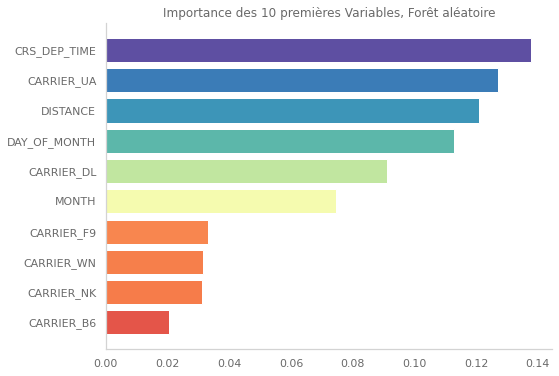

In [50]:
import matplotlib.pyplot as plt
from matplotlib import cm
colors = cm.Spectral(liste_coefs['Coefficient'].head(10) / float(max(liste_coefs['Coefficient'].head(10))))

plt.figure(figsize=(8,6))
plt.title('Importance des 10 premières Variables, Forêt aléatoire')
plt.barh(liste_coefs['Variable'].head(10),liste_coefs['Coefficient'].head(10),color=colors)
plt.gca().invert_yaxis()

### Random Forest optimisé

In [32]:
%%time
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_validate

# Cross validation
rf2 = RandomForestRegressor(n_estimators = 200,
                           max_depth = 30,
                           min_samples_split = 2,
                           n_jobs = -1) # valeur par rapport au résultat de la grid_search

scoring = ['r2', 'neg_mean_squared_error']
scores = cross_validate(rf2, X_train_std, y_train, cv=5,
                        scoring=scoring, return_train_score=False)
# report performance
pd.DataFrame(scores).T

/Users/hui-guan/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/hui-guan/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/hui-guan/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/hui-guan/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_va

CPU times: user 4min 20s, sys: 3min 23s, total: 7min 44s
Wall time: 2h 52min 13s


,0,1,2,3,4
fit_time,"1,922.20","1,888.92","1,978.02","2,168.51","2,354.94"
score_time,3.91,3.28,3.22,3.96,4.63
test_r2,0.19,0.19,0.19,0.19,0.19
test_neg_mean_squared_error,-164.90,-164.95,-165.66,-163.77,-164.51


Le coefficient de determination est faible, proche de 0,2% après une validation croisée à 5 blocs.
Le score mse est très bas.
Le modèle de forêt aléatoire explique peu le comportement de la variable cible.

In [24]:
%%time
# verification sur les données de test
from sklearn.ensemble import RandomForestRegressor

randomForest=RandomForestRegressor(n_estimators = 200,
                           max_depth = 30,
                           min_samples_split = 2,
                           n_jobs = -1)
model=randomForest.fit(X_train_std,y_train)
y_pred_train=model.predict(X_train_std)
r2_train = r2_score(y_train, y_pred_train)

y_pred_test=model.predict(X_test_std)
# Evaluer les scores
r2_test = r2_score(y_test, y_pred_test)
mse=mean_squared_error(y_test,y_pred_test)
r2_train,r2_test,mse

<timed exec>:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


CPU times: user 3h 35min 22s, sys: 1min 38s, total: 3h 37min 1s
Wall time: 19min 19s


(0.6194712795924296, 0.2063924097012706, 161.8807997562499)

En prediction sur le jeu d'entrainement, on trouve un R2=0.61 et sur le jeu de test, un R2=0.2. Il y a un surapprentissage important.

## Ada Boost 

Descriptif des hyperparametres:
* loss: Loss function to be optimized. 'ls','lad','huber','quantile'
* learning_rate: Learning rate shrinks the contribution of each tree by learning_rate
* n_estimators: The number of trees in the ensemble, often increased until no further improvements are seen.
* subsample: The number of samples (rows) used in each tree, set to a value between 0 and 1, often 1.0 to use all samples.
* criterion: function to measure the quality of a split. 'friedman_mse','mse','mae'

In [27]:
%%time
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor

stump = DecisionTreeRegressor(max_depth=1,random_state=72)
model=AdaBoostRegressor(base_estimator=stump,loss='linear',learning_rate=0.5,n_estimators=10)
scoresModele("Ada Boost",model,X_train_std,y_train.values.ravel())

CPU times: user 7min 54s, sys: 54 s, total: 8min 48s
Wall time: 8min 53s


,Modèle,R2,MSE,Durée
0,Ada Boost,-0.21,"1,927.50",533.90


## Gradient Boost 

Descriptif des hyperparametres:
* loss: Loss function to be optimized. 'ls','lad','huber','quantile'
* learning_rate: Learning rate shrinks the contribution of each tree by learning_rate
* n_estimators: The number of trees in the ensemble, often increased until no further improvements are seen.
* subsample: The number of samples (rows) used in each tree, set to a value between 0 and 1, often 1.0 to use all samples.
* criterion: function to measure the quality of a split. 'friedman_mse','mse','mae'

In [31]:
%%time

from sklearn.ensemble import GradientBoostingRegressor

gradientBoost=GradientBoostingRegressor(loss='ls',learning_rate=0.3,n_estimators=100,subsample=0.7,criterion='mse')
scoresModele("Gradient Boost",gradientBoost,X_train_std,y_train.values.ravel())

CPU times: user 12min 49s, sys: 4.94 s, total: 12min 53s
Wall time: 12min 54s


,Modèle,R2,MSE,Durée
0,Gradient Boost,0.06,"1,500.06",774.98


## XGBoost 

Descriptif des hyperparametres:
* n_estimators: The number of trees in the ensemble, often increased until no further improvements are seen.
* max_depth: The maximum depth of each tree, often values are between 1 and 10.
* eta: The learning rate used to weight each model, often set to small values such as 0.3, 0.1, 0.01, or smaller.
* subsample: The number of samples (rows) used in each tree, set to a value between 0 and 1, often 1.0 to use all samples.
* colsample_bytree: Number of features (columns) used in each tree, set to a value between 0 and 1, often 1.0 to use all features.

In [34]:
%%time

from xgboost import XGBRegressor

model=XGBRegressor(eta=0.1,n_estimators=100,max_depth=4,subsample=1,colsample_bytree=0.8)
scoresModele("XGBoost",model,X_train_std,y_train.values.ravel())

CPU times: user 52min 32s, sys: 25.2 s, total: 52min 57s
Wall time: 4min 54s


,Modèle,R2,MSE,Durée
0,XGBoost,0.05,"1,506.90",294.77


## Reseau de neurones

In [33]:
X_train_std.shape, y_train.shape

((688468, 170), (688468, 1))

### Monocouche

In [34]:
import tensorflow as tf
import numpy as np

tf.config.run_functions_eagerly(True) #activation de l'execution en mode dynamique

# Parametres du reseau de neurones
EPOCHS = 60 # iterations
BATCH_SIZE = 256 #taille de l'echantillon par iteration
VERBOSE = 1
NB_CLASSES = 1   # nombre de neurones en sortie
N_HIDDEN = 2013 # nombre de neurones des couches cachees = nombre d'observations/(2*(nombre de neurones input + nombre de neurones output))
VALIDATION_SPLIT = 0.2 # pourcentage des donnees d'entrainement reservées pour la validation
DROPOUT = 0.3

INPUT_SHAPE = X_train_std.shape

In [35]:
# Creation du modele
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(170,
    input_shape=INPUT_SHAPE,
    name='input_layer', 
    activation='relu'))
model.add(tf.keras.layers.Dropout(DROPOUT))
model.add(tf.keras.layers.Dense(N_HIDDEN,
    name='hidden_layer_1',
    activation='relu'))
model.add(tf.keras.layers.Dropout(DROPOUT))
#model.add(tf.keras.layers.Dense(N_HIDDEN,
#    name='hidden_layer_2',
#    activation='relu'))
#model.add(tf.keras.layers.Dropout(DROPOUT))
model.add(tf.keras.layers.Dense(NB_CLASSES,
    name='output_layer',
    activation='linear'))

In [36]:
# Caracteristique/description du modele
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (Dense)          (None, 688468, 170)       29070     
_________________________________________________________________
dropout (Dropout)            (None, 688468, 170)       0         
_________________________________________________________________
hidden_layer_1 (Dense)       (None, 688468, 2013)      344223    
_________________________________________________________________
dropout_1 (Dropout)          (None, 688468, 2013)      0         
_________________________________________________________________
output_layer (Dense)         (None, 688468, 1)         2014      
Total params: 375,307
Trainable params: 375,307
Non-trainable params: 0
_________________________________________________________________


In [37]:
# Compilation
model.compile(optimizer='SGD', #Stochastic Gradient Descent
              loss='MSE', # methode de calcul de cout
              metrics=['mean_squared_error']) # methode d'evaluation

In [39]:
%%time
callbacks = [
  #  Objet History pour monitorer les iterations
  tf.keras.callbacks.History(),
  # Logs pour TensorBoard dans le repertoire './logs' 
  #tf.keras.callbacks.TensorBoard(log_dir='./logs') # activation des logs pour TensorBoard
]

history = model.fit(X_train_std, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS , verbose = VERBOSE, validation_split = 0.2, callbacks = callbacks)

Epoch 1/60
   7/2152 [..............................] - ETA: 37s - loss: 169.3119 - mean_squared_error: 169.3119

/Users/hui-guan/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


2152/2152 [==============================] - ETA: 0s - loss: 175.1884 - mean_squared_error: 175.1884

/Users/hui-guan/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


2152/2152 [==============================] - 37s 17ms/step - loss: 175.1884 - mean_squared_error: 175.1884 - val_loss: 175.1771 - val_mean_squared_error: 175.1771
Epoch 2/60
2150/2152 [============================>.] - ETA: 0s - loss: 174.2733 - mean_squared_error: 174.2733

/Users/hui-guan/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


2152/2152 [==============================] - 39s 18ms/step - loss: 174.2656 - mean_squared_error: 174.2656 - val_loss: 173.3975 - val_mean_squared_error: 173.3975
Epoch 3/60
2151/2152 [============================>.] - ETA: 0s - loss: 173.6880 - mean_squared_error: 173.6880

/Users/hui-guan/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


2152/2152 [==============================] - 37s 17ms/step - loss: 173.6868 - mean_squared_error: 173.6868 - val_loss: 172.6862 - val_mean_squared_error: 172.6862
Epoch 4/60
2151/2152 [============================>.] - ETA: 0s - loss: 173.1843 - mean_squared_error: 173.1843

/Users/hui-guan/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


2152/2152 [==============================] - 36s 17ms/step - loss: 173.1781 - mean_squared_error: 173.1781 - val_loss: 172.6871 - val_mean_squared_error: 172.6871
Epoch 5/60
2152/2152 [==============================] - ETA: 0s - loss: 172.4919 - mean_squared_error: 172.4919

/Users/hui-guan/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


2152/2152 [==============================] - 38s 18ms/step - loss: 172.4919 - mean_squared_error: 172.4919 - val_loss: 172.4953 - val_mean_squared_error: 172.4953
Epoch 6/60
2149/2152 [============================>.] - ETA: 0s - loss: 171.9372 - mean_squared_error: 171.9372

/Users/hui-guan/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


2152/2152 [==============================] - 36s 17ms/step - loss: 171.9356 - mean_squared_error: 171.9356 - val_loss: 171.0095 - val_mean_squared_error: 171.0095
Epoch 7/60
2149/2152 [============================>.] - ETA: 0s - loss: 171.4488 - mean_squared_error: 171.4488

/Users/hui-guan/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


2152/2152 [==============================] - 36s 17ms/step - loss: 171.4393 - mean_squared_error: 171.4393 - val_loss: 171.8228 - val_mean_squared_error: 171.8228
Epoch 8/60
2152/2152 [==============================] - ETA: 0s - loss: 170.9414 - mean_squared_error: 170.9414

/Users/hui-guan/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


2152/2152 [==============================] - 36s 17ms/step - loss: 170.9414 - mean_squared_error: 170.9414 - val_loss: 170.2369 - val_mean_squared_error: 170.2369
Epoch 9/60
2151/2152 [============================>.] - ETA: 0s - loss: 170.4841 - mean_squared_error: 170.4841

/Users/hui-guan/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


2152/2152 [==============================] - 35s 16ms/step - loss: 170.4808 - mean_squared_error: 170.4808 - val_loss: 170.5039 - val_mean_squared_error: 170.5039
Epoch 10/60
2150/2152 [============================>.] - ETA: 0s - loss: 169.9695 - mean_squared_error: 169.9695

/Users/hui-guan/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


2152/2152 [==============================] - 35s 16ms/step - loss: 169.9791 - mean_squared_error: 169.9791 - val_loss: 170.2567 - val_mean_squared_error: 170.2567
Epoch 11/60
2151/2152 [============================>.] - ETA: 0s - loss: 169.6993 - mean_squared_error: 169.6993

/Users/hui-guan/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


2152/2152 [==============================] - 35s 16ms/step - loss: 169.7037 - mean_squared_error: 169.7037 - val_loss: 170.3247 - val_mean_squared_error: 170.3247
Epoch 12/60
2150/2152 [============================>.] - ETA: 0s - loss: 169.4767 - mean_squared_error: 169.4767

/Users/hui-guan/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


2152/2152 [==============================] - 34s 16ms/step - loss: 169.4909 - mean_squared_error: 169.4909 - val_loss: 169.2968 - val_mean_squared_error: 169.2968
Epoch 13/60
2151/2152 [============================>.] - ETA: 0s - loss: 169.3052 - mean_squared_error: 169.3052

/Users/hui-guan/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


2152/2152 [==============================] - 34s 16ms/step - loss: 169.3012 - mean_squared_error: 169.3012 - val_loss: 168.9946 - val_mean_squared_error: 168.9946
Epoch 14/60
2150/2152 [============================>.] - ETA: 0s - loss: 168.7928 - mean_squared_error: 168.7928

/Users/hui-guan/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


2152/2152 [==============================] - 35s 16ms/step - loss: 168.7945 - mean_squared_error: 168.7945 - val_loss: 169.1866 - val_mean_squared_error: 169.1866
Epoch 15/60
2152/2152 [==============================] - ETA: 0s - loss: 168.6866 - mean_squared_error: 168.6866

/Users/hui-guan/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


2152/2152 [==============================] - 34s 16ms/step - loss: 168.6866 - mean_squared_error: 168.6866 - val_loss: 169.4633 - val_mean_squared_error: 169.4633
Epoch 16/60
2152/2152 [==============================] - ETA: 0s - loss: 168.2479 - mean_squared_error: 168.2479

/Users/hui-guan/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


2152/2152 [==============================] - 37s 17ms/step - loss: 168.2479 - mean_squared_error: 168.2479 - val_loss: 168.6751 - val_mean_squared_error: 168.6751
Epoch 17/60
2152/2152 [==============================] - ETA: 0s - loss: 168.1721 - mean_squared_error: 168.1721

/Users/hui-guan/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


2152/2152 [==============================] - 42s 19ms/step - loss: 168.1721 - mean_squared_error: 168.1721 - val_loss: 168.2888 - val_mean_squared_error: 168.2888
Epoch 18/60
2151/2152 [============================>.] - ETA: 0s - loss: 167.8252 - mean_squared_error: 167.8252

/Users/hui-guan/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


2152/2152 [==============================] - 36s 17ms/step - loss: 167.8369 - mean_squared_error: 167.8369 - val_loss: 169.2018 - val_mean_squared_error: 169.2018
Epoch 19/60
2151/2152 [============================>.] - ETA: 0s - loss: 167.5491 - mean_squared_error: 167.5491

/Users/hui-guan/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


2152/2152 [==============================] - 37s 17ms/step - loss: 167.5420 - mean_squared_error: 167.5420 - val_loss: 168.7355 - val_mean_squared_error: 168.7355
Epoch 20/60
2152/2152 [==============================] - ETA: 0s - loss: 167.3941 - mean_squared_error: 167.3941

/Users/hui-guan/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


2152/2152 [==============================] - 37s 17ms/step - loss: 167.3941 - mean_squared_error: 167.3941 - val_loss: 168.2226 - val_mean_squared_error: 168.2226
Epoch 21/60
2151/2152 [============================>.] - ETA: 0s - loss: 167.2296 - mean_squared_error: 167.2296

/Users/hui-guan/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


2152/2152 [==============================] - 38s 17ms/step - loss: 167.2200 - mean_squared_error: 167.2200 - val_loss: 168.7989 - val_mean_squared_error: 168.7989
Epoch 22/60
2151/2152 [============================>.] - ETA: 0s - loss: 167.0231 - mean_squared_error: 167.0231

/Users/hui-guan/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


2152/2152 [==============================] - 36s 17ms/step - loss: 167.0332 - mean_squared_error: 167.0332 - val_loss: 168.4416 - val_mean_squared_error: 168.4416
Epoch 23/60
2152/2152 [==============================] - ETA: 0s - loss: 166.8604 - mean_squared_error: 166.8604

/Users/hui-guan/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


2152/2152 [==============================] - 40s 18ms/step - loss: 166.8604 - mean_squared_error: 166.8604 - val_loss: 169.4875 - val_mean_squared_error: 169.4875
Epoch 24/60
2149/2152 [============================>.] - ETA: 0s - loss: 166.6259 - mean_squared_error: 166.6259

/Users/hui-guan/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


2152/2152 [==============================] - 38s 17ms/step - loss: 166.6213 - mean_squared_error: 166.6213 - val_loss: 167.0364 - val_mean_squared_error: 167.0364
Epoch 25/60
2152/2152 [==============================] - ETA: 0s - loss: 166.6214 - mean_squared_error: 166.6214

/Users/hui-guan/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


2152/2152 [==============================] - 41s 19ms/step - loss: 166.6214 - mean_squared_error: 166.6214 - val_loss: 167.7156 - val_mean_squared_error: 167.7156
Epoch 26/60
2152/2152 [==============================] - ETA: 0s - loss: 166.2541 - mean_squared_error: 166.2541

/Users/hui-guan/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


2152/2152 [==============================] - 38s 17ms/step - loss: 166.2541 - mean_squared_error: 166.2541 - val_loss: 167.3168 - val_mean_squared_error: 167.3168
Epoch 27/60
2150/2152 [============================>.] - ETA: 0s - loss: 166.2370 - mean_squared_error: 166.2370

/Users/hui-guan/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


2152/2152 [==============================] - 38s 18ms/step - loss: 166.2410 - mean_squared_error: 166.2410 - val_loss: 168.3405 - val_mean_squared_error: 168.3405
Epoch 28/60
2149/2152 [============================>.] - ETA: 0s - loss: 166.0010 - mean_squared_error: 166.0010

/Users/hui-guan/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


2152/2152 [==============================] - 35s 16ms/step - loss: 165.9982 - mean_squared_error: 165.9982 - val_loss: 167.2163 - val_mean_squared_error: 167.2163
Epoch 29/60
2149/2152 [============================>.] - ETA: 0s - loss: 165.9115 - mean_squared_error: 165.9115

/Users/hui-guan/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


2152/2152 [==============================] - 35s 16ms/step - loss: 165.8925 - mean_squared_error: 165.8925 - val_loss: 166.5967 - val_mean_squared_error: 166.5967
Epoch 30/60
2152/2152 [==============================] - ETA: 0s - loss: 165.8323 - mean_squared_error: 165.8323

/Users/hui-guan/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


2152/2152 [==============================] - 38s 18ms/step - loss: 165.8323 - mean_squared_error: 165.8323 - val_loss: 167.2706 - val_mean_squared_error: 167.2706
Epoch 31/60
2150/2152 [============================>.] - ETA: 0s - loss: 165.6484 - mean_squared_error: 165.6484

/Users/hui-guan/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


2152/2152 [==============================] - 35s 16ms/step - loss: 165.6428 - mean_squared_error: 165.6428 - val_loss: 166.6294 - val_mean_squared_error: 166.6294
Epoch 32/60
2151/2152 [============================>.] - ETA: 0s - loss: 165.2704 - mean_squared_error: 165.2704

/Users/hui-guan/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


2152/2152 [==============================] - 37s 17ms/step - loss: 165.2820 - mean_squared_error: 165.2820 - val_loss: 168.0161 - val_mean_squared_error: 168.0161
Epoch 33/60
2150/2152 [============================>.] - ETA: 0s - loss: 165.2843 - mean_squared_error: 165.2843

/Users/hui-guan/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


2152/2152 [==============================] - 36s 17ms/step - loss: 165.2939 - mean_squared_error: 165.2939 - val_loss: 166.6460 - val_mean_squared_error: 166.6460
Epoch 34/60
2152/2152 [==============================] - ETA: 0s - loss: 165.1523 - mean_squared_error: 165.1523

/Users/hui-guan/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


2152/2152 [==============================] - 40s 18ms/step - loss: 165.1523 - mean_squared_error: 165.1523 - val_loss: 167.4878 - val_mean_squared_error: 167.4878
Epoch 35/60
2149/2152 [============================>.] - ETA: 0s - loss: 164.9851 - mean_squared_error: 164.9851

/Users/hui-guan/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


2152/2152 [==============================] - 38s 18ms/step - loss: 164.9951 - mean_squared_error: 164.9951 - val_loss: 167.5714 - val_mean_squared_error: 167.5714
Epoch 36/60
2151/2152 [============================>.] - ETA: 0s - loss: 164.9174 - mean_squared_error: 164.9174

/Users/hui-guan/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


2152/2152 [==============================] - 38s 18ms/step - loss: 164.9144 - mean_squared_error: 164.9144 - val_loss: 166.8338 - val_mean_squared_error: 166.8338
Epoch 37/60
2150/2152 [============================>.] - ETA: 0s - loss: 164.8465 - mean_squared_error: 164.8465

/Users/hui-guan/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


2152/2152 [==============================] - 40s 18ms/step - loss: 164.8481 - mean_squared_error: 164.8481 - val_loss: 166.9198 - val_mean_squared_error: 166.9198
Epoch 38/60
2151/2152 [============================>.] - ETA: 0s - loss: 164.6405 - mean_squared_error: 164.6405

/Users/hui-guan/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


2152/2152 [==============================] - 40s 19ms/step - loss: 164.6423 - mean_squared_error: 164.6423 - val_loss: 166.4637 - val_mean_squared_error: 166.4637
Epoch 39/60
2151/2152 [============================>.] - ETA: 0s - loss: 164.4565 - mean_squared_error: 164.4565

/Users/hui-guan/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


2152/2152 [==============================] - 39s 18ms/step - loss: 164.4591 - mean_squared_error: 164.4591 - val_loss: 166.3419 - val_mean_squared_error: 166.3419
Epoch 40/60
2149/2152 [============================>.] - ETA: 0s - loss: 164.4520 - mean_squared_error: 164.4520

/Users/hui-guan/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


2152/2152 [==============================] - 36s 17ms/step - loss: 164.4566 - mean_squared_error: 164.4566 - val_loss: 166.1129 - val_mean_squared_error: 166.1129
Epoch 41/60
2149/2152 [============================>.] - ETA: 0s - loss: 164.3878 - mean_squared_error: 164.3878

/Users/hui-guan/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


2152/2152 [==============================] - 37s 17ms/step - loss: 164.3937 - mean_squared_error: 164.3937 - val_loss: 166.7597 - val_mean_squared_error: 166.7597
Epoch 42/60
2150/2152 [============================>.] - ETA: 0s - loss: 164.1256 - mean_squared_error: 164.1256

/Users/hui-guan/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


2152/2152 [==============================] - 35s 16ms/step - loss: 164.1311 - mean_squared_error: 164.1311 - val_loss: 167.1634 - val_mean_squared_error: 167.1634
Epoch 43/60
2150/2152 [============================>.] - ETA: 0s - loss: 164.1976 - mean_squared_error: 164.1976

/Users/hui-guan/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


2152/2152 [==============================] - 36s 17ms/step - loss: 164.1956 - mean_squared_error: 164.1956 - val_loss: 166.8883 - val_mean_squared_error: 166.8883
Epoch 44/60
2149/2152 [============================>.] - ETA: 0s - loss: 163.9453 - mean_squared_error: 163.9453

/Users/hui-guan/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


2152/2152 [==============================] - 39s 18ms/step - loss: 163.9491 - mean_squared_error: 163.9491 - val_loss: 166.4666 - val_mean_squared_error: 166.4666
Epoch 45/60
2151/2152 [============================>.] - ETA: 0s - loss: 164.0774 - mean_squared_error: 164.0774

/Users/hui-guan/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


2152/2152 [==============================] - 37s 17ms/step - loss: 164.0776 - mean_squared_error: 164.0776 - val_loss: 166.3922 - val_mean_squared_error: 166.3922
Epoch 46/60
2151/2152 [============================>.] - ETA: 0s - loss: 163.8055 - mean_squared_error: 163.8055

/Users/hui-guan/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


2152/2152 [==============================] - 37s 17ms/step - loss: 163.8024 - mean_squared_error: 163.8024 - val_loss: 169.1074 - val_mean_squared_error: 169.1074
Epoch 47/60
2150/2152 [============================>.] - ETA: 0s - loss: 163.7327 - mean_squared_error: 163.7327

/Users/hui-guan/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


2152/2152 [==============================] - 36s 17ms/step - loss: 163.7313 - mean_squared_error: 163.7313 - val_loss: 167.3068 - val_mean_squared_error: 167.3068
Epoch 48/60
2152/2152 [==============================] - ETA: 0s - loss: 163.7413 - mean_squared_error: 163.7413

/Users/hui-guan/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


2152/2152 [==============================] - 35s 16ms/step - loss: 163.7413 - mean_squared_error: 163.7413 - val_loss: 166.3818 - val_mean_squared_error: 166.3818
Epoch 49/60
2150/2152 [============================>.] - ETA: 0s - loss: 163.5194 - mean_squared_error: 163.5194

/Users/hui-guan/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


2152/2152 [==============================] - 36s 17ms/step - loss: 163.5213 - mean_squared_error: 163.5213 - val_loss: 166.2090 - val_mean_squared_error: 166.2090
Epoch 50/60
2150/2152 [============================>.] - ETA: 0s - loss: 163.5416 - mean_squared_error: 163.5416

/Users/hui-guan/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


2152/2152 [==============================] - 39s 18ms/step - loss: 163.5370 - mean_squared_error: 163.5370 - val_loss: 166.6046 - val_mean_squared_error: 166.6046
Epoch 51/60
2152/2152 [==============================] - ETA: 0s - loss: 163.3325 - mean_squared_error: 163.3325

/Users/hui-guan/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


2152/2152 [==============================] - 37s 17ms/step - loss: 163.3325 - mean_squared_error: 163.3325 - val_loss: 167.0281 - val_mean_squared_error: 167.0281
Epoch 52/60
2152/2152 [==============================] - ETA: 0s - loss: 163.2931 - mean_squared_error: 163.2931

/Users/hui-guan/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


2152/2152 [==============================] - 38s 18ms/step - loss: 163.2931 - mean_squared_error: 163.2931 - val_loss: 166.2813 - val_mean_squared_error: 166.2813
Epoch 53/60
2149/2152 [============================>.] - ETA: 0s - loss: 163.2288 - mean_squared_error: 163.2288

/Users/hui-guan/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


2152/2152 [==============================] - 38s 18ms/step - loss: 163.2125 - mean_squared_error: 163.2125 - val_loss: 166.8514 - val_mean_squared_error: 166.8514
Epoch 54/60
2151/2152 [============================>.] - ETA: 0s - loss: 163.0502 - mean_squared_error: 163.0502

/Users/hui-guan/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


2152/2152 [==============================] - 39s 18ms/step - loss: 163.0500 - mean_squared_error: 163.0500 - val_loss: 166.5359 - val_mean_squared_error: 166.5359
Epoch 55/60
2151/2152 [============================>.] - ETA: 0s - loss: 162.9935 - mean_squared_error: 162.9935

/Users/hui-guan/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


2152/2152 [==============================] - 37s 17ms/step - loss: 162.9910 - mean_squared_error: 162.9910 - val_loss: 166.5787 - val_mean_squared_error: 166.5787
Epoch 56/60
2150/2152 [============================>.] - ETA: 0s - loss: 162.8125 - mean_squared_error: 162.8125

/Users/hui-guan/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


2152/2152 [==============================] - 37s 17ms/step - loss: 162.8104 - mean_squared_error: 162.8104 - val_loss: 166.3565 - val_mean_squared_error: 166.3565
Epoch 57/60
2150/2152 [============================>.] - ETA: 0s - loss: 162.9123 - mean_squared_error: 162.9123

/Users/hui-guan/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


2152/2152 [==============================] - 37s 17ms/step - loss: 162.9151 - mean_squared_error: 162.9151 - val_loss: 165.9631 - val_mean_squared_error: 165.9631
Epoch 58/60
2150/2152 [============================>.] - ETA: 0s - loss: 162.9341 - mean_squared_error: 162.9341

/Users/hui-guan/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


2152/2152 [==============================] - 37s 17ms/step - loss: 162.9247 - mean_squared_error: 162.9247 - val_loss: 166.6302 - val_mean_squared_error: 166.6302
Epoch 59/60
2152/2152 [==============================] - ETA: 0s - loss: 162.7810 - mean_squared_error: 162.7810

/Users/hui-guan/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


2152/2152 [==============================] - 38s 18ms/step - loss: 162.7810 - mean_squared_error: 162.7810 - val_loss: 165.9097 - val_mean_squared_error: 165.9097
Epoch 60/60
2151/2152 [============================>.] - ETA: 0s - loss: 162.6641 - mean_squared_error: 162.6641

/Users/hui-guan/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


2152/2152 [==============================] - 37s 17ms/step - loss: 162.6642 - mean_squared_error: 162.6642 - val_loss: 166.3523 - val_mean_squared_error: 166.3523
CPU times: user 1h 46min, sys: 11min 29s, total: 1h 57min 30s
Wall time: 37min 2s


0

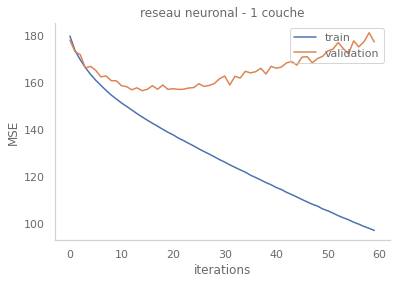

In [39]:
import matplotlib.pyplot as plt

plt.plot(history.history['mean_squared_error'])
plt.plot(history.history['val_mean_squared_error'])
plt.title('reseau neuronal - 1 couche')
plt.ylabel('MSE')
plt.xlabel('iterations')
plt.legend(['train' , 'validation'] , loc = 'upper right')
plt.show()

Le fort écart entre la courbe MSE de validation, et la courbe MSE d'entrainement est un indicateur de surapprentissage.

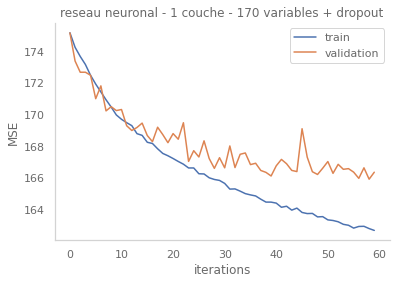

In [43]:
import matplotlib.pyplot as plt

plt.plot(history.history['mean_squared_error'])
plt.plot(history.history['val_mean_squared_error'])
plt.title('reseau neuronal - 1 couche - 170 variables + dropout')
plt.ylabel('MSE')
plt.xlabel('iterations')
plt.legend(['train' , 'validation'] , loc = 'upper right')
plt.show()

En ajoutant dropout sur le reseau de neurone, on réduit notablement le surapprentissage.

In [49]:
X_train_std.shape,y_train.shape

((688468, 170), (688468, 1))

In [77]:
y_train_tf=np.squeeze(y_train) #helps to get rid of useless one dimension arrays 
y_pred=np.squeeze(model.predict_on_batch(X_train_std))

In [79]:
y_test_tf=np.squeeze(y_test) #helps to get rid of useless one dimension arrays 
y_pred=np.squeeze(model.predict_on_batch(X_test_std))

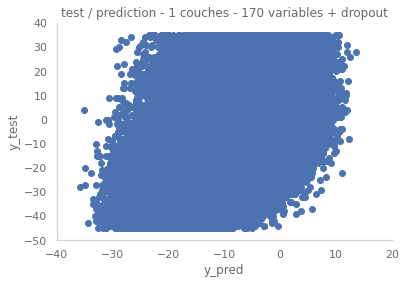

In [80]:
import matplotlib.pyplot as plt
plt.rcParams['agg.path.chunksize'] = 10000
## définir les limites des axes
plt.xlim(-40, 20)
plt.ylim(-50, 40)

plt.scatter(np.squeeze(y_pred), np.squeeze(y_test))
plt.title('test / prediction - 1 couches - 170 variables + dropout')
plt.xlabel('y_pred')
plt.ylabel('y_test')
plt.show()

### 2 couches

#### Reseau de neurones à 2 couches - régularisation L1 (lasso)

In [29]:
# Creation du modele avec régularisation L1 (Lasso)
model_l1 = tf.keras.models.Sequential()
model_l1.add(tf.keras.layers.Dense(604,
    input_shape=INPUT_SHAPE,
    name='input_layer', 
    activation='relu',
    kernel_regularizer='l1'))
model_l1.add(tf.keras.layers.Dense(N_HIDDEN,
    name='hidden_layer_1',
    activation='relu'))
model_l1.add(tf.keras.layers.Dense(N_HIDDEN,
    name='hidden_layer_2',
    activation='relu'))
model_l1.add(tf.keras.layers.Dense(NB_CLASSES,
    name='output_layer',
    activation='linear'))

In [30]:
# Caracteristique/description du modele
model_l1.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (Dense)          (None, 845039, 604)       365420    
_________________________________________________________________
hidden_layer_1 (Dense)       (None, 845039, 698)       422290    
_________________________________________________________________
hidden_layer_2 (Dense)       (None, 845039, 698)       487902    
_________________________________________________________________
output_layer (Dense)         (None, 845039, 1)         699       
Total params: 1,276,311
Trainable params: 1,276,311
Non-trainable params: 0
_________________________________________________________________


In [31]:
# Compilation
model_l1.compile(optimizer='SGD', #Stochastic Gradient Descent
              loss='MSE', # methode de calcul de cout
              metrics=['mean_squared_error']) # methode d'evaluation

In [32]:
%%time
callbacks = [
  #  Create a history object to monitor iterations
  tf.keras.callbacks.History(),
  # Write TensorBoard logs to './logs' directory
  #tf.keras.callbacks.TensorBoard(log_dir='./logs') # activation des logs pour TensorBoard
]

history_l1 = model_l1.fit(X_train_std, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS , verbose = VERBOSE, validation_split = 0.2, callbacks = callbacks)

Epoch 1/60
   1/2641 [..............................] - ETA: 3:15 - loss: 337.3220 - mean_squared_error: 208.9287

/Users/hui-guan/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(
/Users/hui-guan/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


2641/2641 [==============================] - ETA: 0s - loss: 225.2313 - mean_squared_error: 186.1393

/Users/hui-guan/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


2641/2641 [==============================] - 54s 21ms/step - loss: 225.2209 - mean_squared_error: 186.1379 - val_loss: 187.2616 - val_mean_squared_error: 183.1612
Epoch 2/60
2641/2641 [==============================] - 54s 20ms/step - loss: 182.1759 - mean_squared_error: 177.9924 - val_loss: 181.2618 - val_mean_squared_error: 176.9084
Epoch 3/60
2641/2641 [==============================] - 55s 21ms/step - loss: 180.8354 - mean_squared_error: 176.4028 - val_loss: 180.0115 - val_mean_squared_error: 175.3247
Epoch 4/60
2641/2641 [==============================] - 56s 21ms/step - loss: 179.7031 - mean_squared_error: 174.9405 - val_loss: 180.6590 - val_mean_squared_error: 175.6686
Epoch 5/60
2641/2641 [==============================] - 56s 21ms/step - loss: 178.2182 - mean_squared_error: 173.1072 - val_loss: 178.2269 - val_mean_squared_error: 172.8507
Epoch 6/60
2641/2641 [==============================] - 55s 21ms/step - loss: 176.7640 - mean_squared_error: 171.3237 - val_loss: 178.1607 - 

Epoch 48/60
2641/2641 [==============================] - 57s 21ms/step - loss: 149.9477 - mean_squared_error: 141.9496 - val_loss: 167.4868 - val_mean_squared_error: 159.4389
Epoch 49/60
2641/2641 [==============================] - 55s 21ms/step - loss: 150.1562 - mean_squared_error: 142.0835 - val_loss: 167.6669 - val_mean_squared_error: 159.6088
Epoch 50/60
2641/2641 [==============================] - 54s 21ms/step - loss: 149.5996 - mean_squared_error: 141.5236 - val_loss: 166.5993 - val_mean_squared_error: 158.5242
Epoch 51/60
2641/2641 [==============================] - 54s 20ms/step - loss: 148.9689 - mean_squared_error: 140.8388 - val_loss: 167.3691 - val_mean_squared_error: 159.2309
Epoch 52/60
2641/2641 [==============================] - 54s 21ms/step - loss: 148.7732 - mean_squared_error: 140.5823 - val_loss: 169.7373 - val_mean_squared_error: 161.5859
Epoch 53/60
2641/2641 [==============================] - 54s 21ms/step - loss: 147.9027 - mean_squared_error: 139.6838 - val_

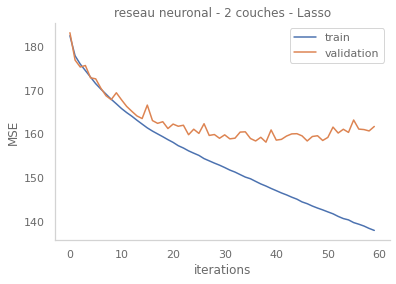

In [33]:
import matplotlib.pyplot as plt

plt.plot(history_l1.history['mean_squared_error'])
plt.plot(history_l1.history['val_mean_squared_error'])
plt.title('reseau neuronal - 2 couches - Lasso')
plt.ylabel('MSE')
plt.xlabel('iterations')
plt.legend(['train' , 'validation'] , loc = 'upper right')
plt.show()

In [34]:
y_train_tf=np.squeeze(y_train) #helps to get rid of useless one dimension arrays 
y_pred=np.squeeze(model_l1.predict_on_batch(X_train_std))

In [37]:
y_test_tf=np.squeeze(y_test) #helps to get rid of useless one dimension arrays 
y_pred=np.squeeze(model_l1.predict_on_batch(X_test_std))

In [35]:
# 2 couches sur les donnees d'entrainement
r2_score(y_train_tf,y_pred)

<tf.Tensor: shape=(), dtype=float64, numpy=0.29324275238668795>

In [38]:
# 2 couches sur les donnees de test
r2_score(y_test_tf,y_pred)

<tf.Tensor: shape=(), dtype=float64, numpy=0.1863741972204811>

#### Reseau de neurones à 2 couches - régularisation L2 (ridge)

In [93]:
# Creation du modele avec régularisation L1 (Lasso)
model_l2 = tf.keras.models.Sequential()
model_l2.add(tf.keras.layers.Dense(601,
    input_shape=INPUT_SHAPE,
    name='input_layer', 
    activation='relu',
    kernel_regularizer='l2'))
model_l2.add(tf.keras.layers.Dense(N_HIDDEN,
    name='hidden_layer_1',
    activation='relu'))
model_l2.add(tf.keras.layers.Dense(N_HIDDEN,
    name='hidden_layer_2',
    activation='relu'))
model_l2.add(tf.keras.layers.Dense(NB_CLASSES,
    name='output_layer',
    activation='linear'))

In [94]:
# Caracteristique/description du modele
model_l2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (Dense)          (None, 845039, 601)       361201    
_________________________________________________________________
hidden_layer_1 (Dense)       (None, 845039, 352)       211904    
_________________________________________________________________
hidden_layer_2 (Dense)       (None, 845039, 352)       124256    
_________________________________________________________________
output_layer (Dense)         (None, 845039, 1)         353       
Total params: 697,714
Trainable params: 697,714
Non-trainable params: 0
_________________________________________________________________


In [95]:
# Compilation
model_l2.compile(optimizer='SGD', #Stochastic Gradient Descent
              loss='MSE', # methode de calcul de cout
              metrics=['mean_squared_error']) # methode d'evaluation

In [42]:
%%time
callbacks = [
  #  Create a history object to monitor iterations
  tf.keras.callbacks.History(),
  # Write TensorBoard logs to './logs' directory
  #tf.keras.callbacks.TensorBoard(log_dir='./logs') # activation des logs pour TensorBoard
]

history_l2 = model_l2.fit(X_train_std, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS , verbose = VERBOSE, validation_split = 0.2, callbacks = callbacks)

Epoch 1/60
   7/2641 [..............................] - ETA: 52s - loss: 234.5605 - mean_squared_error: 228.5286

/Users/hui-guan/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


2641/2641 [==============================] - ETA: 0s - loss: 190.1446 - mean_squared_error: 184.8527

/Users/hui-guan/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


2641/2641 [==============================] - 53s 20ms/step - loss: 190.1427 - mean_squared_error: 184.8511 - val_loss: 180.8774 - val_mean_squared_error: 176.8660
Epoch 2/60
2641/2641 [==============================] - 56s 21ms/step - loss: 178.7090 - mean_squared_error: 174.8009 - val_loss: 178.9048 - val_mean_squared_error: 175.0946
Epoch 3/60
2641/2641 [==============================] - 55s 21ms/step - loss: 176.1475 - mean_squared_error: 172.2403 - val_loss: 180.8204 - val_mean_squared_error: 176.5587
Epoch 4/60
2641/2641 [==============================] - 54s 21ms/step - loss: 175.6371 - mean_squared_error: 171.1862 - val_loss: 175.8955 - val_mean_squared_error: 171.0364
Epoch 5/60
2641/2641 [==============================] - 55s 21ms/step - loss: 173.1920 - mean_squared_error: 168.1557 - val_loss: 174.6368 - val_mean_squared_error: 169.2299
Epoch 6/60
2641/2641 [==============================] - 56s 21ms/step - loss: 173.1266 - mean_squared_error: 167.5453 - val_loss: 175.1105 - 

Epoch 48/60
2641/2641 [==============================] - 55s 21ms/step - loss: 156.2547 - mean_squared_error: 146.4726 - val_loss: 168.6431 - val_mean_squared_error: 158.9395
Epoch 49/60
2641/2641 [==============================] - 55s 21ms/step - loss: 155.4806 - mean_squared_error: 145.6450 - val_loss: 171.0119 - val_mean_squared_error: 161.2254
Epoch 50/60
2641/2641 [==============================] - 55s 21ms/step - loss: 155.1802 - mean_squared_error: 145.2794 - val_loss: 166.6660 - val_mean_squared_error: 156.8528
Epoch 51/60
2641/2641 [==============================] - 55s 21ms/step - loss: 154.7596 - mean_squared_error: 144.8451 - val_loss: 168.3368 - val_mean_squared_error: 158.4583
Epoch 52/60
2641/2641 [==============================] - 55s 21ms/step - loss: 154.7049 - mean_squared_error: 144.7303 - val_loss: 169.4375 - val_mean_squared_error: 159.5007
Epoch 53/60
2641/2641 [==============================] - 55s 21ms/step - loss: 154.4254 - mean_squared_error: 144.4077 - val_

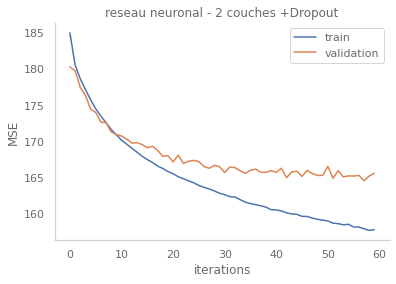

In [119]:
import matplotlib.pyplot as plt

plt.plot(history.history['mean_squared_error'])
plt.plot(history.history['val_mean_squared_error'])
plt.title('reseau neuronal - 2 couches +Dropout')
plt.ylabel('MSE')
plt.xlabel('iterations')
plt.legend(['train' , 'validation'] , loc = 'upper right')
plt.show()

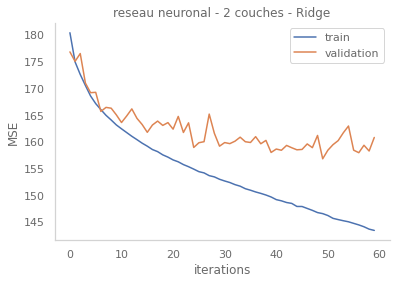

In [43]:
import matplotlib.pyplot as plt

plt.plot(history_l2.history['mean_squared_error'])
plt.plot(history_l2.history['val_mean_squared_error'])
plt.title('reseau neuronal - 2 couches - Ridge')
plt.ylabel('MSE')
plt.xlabel('iterations')
plt.legend(['train' , 'validation'] , loc = 'upper right')
plt.show()

In [47]:
y_train_tf=np.squeeze(y_train) #helps to get rid of useless one dimension arrays 
y_pred=np.squeeze(model_l2.predict_on_batch(X_train_std))

In [48]:
# 2 couches sur les donnees d'entrainement
r2_score(y_train_tf,y_pred)

<tf.Tensor: shape=(), dtype=float64, numpy=0.2657822237214953>

In [49]:
y_test_tf=np.squeeze(y_test) #helps to get rid of useless one dimension arrays 
y_pred=np.squeeze(model_l2.predict_on_batch(X_test_std))

In [50]:
# 2 couches sur les donnees de test
r2_score(y_test_tf,y_pred)

<tf.Tensor: shape=(), dtype=float64, numpy=0.19284157937821267>

In [120]:
y_train_tf=np.squeeze(y_train) #helps to get rid of useless one dimension arrays 
y_pred=np.squeeze(model.predict_on_batch(X_train_std))

In [121]:
# 2 couches sur les donnees d'entrainement + dropout
r2_score(y_train_tf,y_pred)

<tf.Tensor: shape=(), dtype=float64, numpy=0.22391191844088143>

#### Reseau de neurones à 2 couches - régularisation L1L2 (ElasticNet)

In [98]:
# Creation du modele avec régularisation L1 (Lasso)
model_l12 = tf.keras.models.Sequential()
model_l12.add(tf.keras.layers.Dense(601,
    input_shape=INPUT_SHAPE,
    name='input_layer', 
    activation='relu',
    kernel_regularizer='l1_l2'))
model_l12.add(tf.keras.layers.Dense(N_HIDDEN,
    name='hidden_layer_1',
    activation='relu'))
model_l12.add(tf.keras.layers.Dense(N_HIDDEN,
    name='hidden_layer_2',
    activation='relu'))
model_l12.add(tf.keras.layers.Dense(NB_CLASSES,
    name='output_layer',
    activation='linear'))

In [99]:
# Caracteristique/description du modele
model_l12.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (Dense)          (None, 845039, 601)       361201    
_________________________________________________________________
hidden_layer_1 (Dense)       (None, 845039, 352)       211904    
_________________________________________________________________
hidden_layer_2 (Dense)       (None, 845039, 352)       124256    
_________________________________________________________________
output_layer (Dense)         (None, 845039, 1)         353       
Total params: 697,714
Trainable params: 697,714
Non-trainable params: 0
_________________________________________________________________


In [100]:
# Compilation
model_l12.compile(optimizer='SGD', #Stochastic Gradient Descent
              loss='MSE', # methode de calcul de cout
              metrics=['mean_squared_error']) # methode d'evaluation

In [101]:
%%time
callbacks = [
  #  Create a history object to monitor iterations
  tf.keras.callbacks.History(),
  # Write TensorBoard logs to './logs' directory
  #tf.keras.callbacks.TensorBoard(log_dir='./logs') # activation des logs pour TensorBoard
]

history_l12 = model_l12.fit(X_train_std, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS , verbose = VERBOSE, validation_split = 0.2, callbacks = callbacks)

Epoch 1/60
   4/2641 [..............................] - ETA: 47s - loss: 358.6576 - mean_squared_error: 225.5460 

/Users/hui-guan/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


2641/2641 [==============================] - ETA: 0s - loss: 226.2803 - mean_squared_error: 187.4586

/Users/hui-guan/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


2641/2641 [==============================] - 49s 19ms/step - loss: 226.2700 - mean_squared_error: 187.4573 - val_loss: 187.6618 - val_mean_squared_error: 183.2335
Epoch 2/60
2641/2641 [==============================] - 47s 18ms/step - loss: 184.9551 - mean_squared_error: 180.5084 - val_loss: 184.5472 - val_mean_squared_error: 179.9585
Epoch 3/60
2641/2641 [==============================] - 47s 18ms/step - loss: 183.7466 - mean_squared_error: 179.0324 - val_loss: 185.9038 - val_mean_squared_error: 180.8628
Epoch 4/60
2641/2641 [==============================] - 45s 17ms/step - loss: 183.4830 - mean_squared_error: 178.4075 - val_loss: 185.9309 - val_mean_squared_error: 180.5799
Epoch 5/60
2641/2641 [==============================] - 45s 17ms/step - loss: 182.9489 - mean_squared_error: 177.5137 - val_loss: 182.3475 - val_mean_squared_error: 176.7594
Epoch 6/60
2641/2641 [==============================] - 45s 17ms/step - loss: 182.0055 - mean_squared_error: 176.3217 - val_loss: 182.8790 - 

Epoch 48/60
2641/2641 [==============================] - 53s 20ms/step - loss: 165.7436 - mean_squared_error: 156.9378 - val_loss: 174.3625 - val_mean_squared_error: 165.5446
Epoch 49/60
2641/2641 [==============================] - 53s 20ms/step - loss: 165.3077 - mean_squared_error: 156.4635 - val_loss: 173.9757 - val_mean_squared_error: 165.1879
Epoch 50/60
2641/2641 [==============================] - 54s 20ms/step - loss: 165.5627 - mean_squared_error: 156.6935 - val_loss: 172.6685 - val_mean_squared_error: 163.8302
Epoch 51/60
2641/2641 [==============================] - 53s 20ms/step - loss: 165.4494 - mean_squared_error: 156.5265 - val_loss: 172.0647 - val_mean_squared_error: 163.1459
Epoch 52/60
2641/2641 [==============================] - 52s 20ms/step - loss: 164.3994 - mean_squared_error: 155.4098 - val_loss: 171.2130 - val_mean_squared_error: 162.1663
Epoch 53/60
2641/2641 [==============================] - 55s 21ms/step - loss: 164.9438 - mean_squared_error: 155.8750 - val_

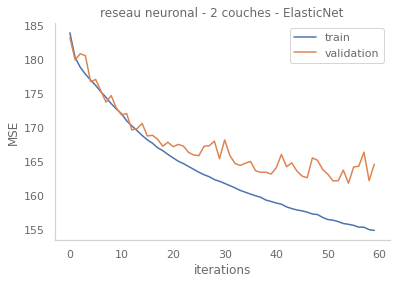

In [102]:
import matplotlib.pyplot as plt

plt.plot(history_l12.history['mean_squared_error'])
plt.plot(history_l12.history['val_mean_squared_error'])
plt.title('reseau neuronal - 2 couches - ElasticNet')
plt.ylabel('MSE')
plt.xlabel('iterations')
plt.legend(['train' , 'validation'] , loc = 'upper right')
plt.show()

In [103]:
y_train_tf=np.squeeze(y_train) #helps to get rid of useless one dimension arrays 
y_pred=np.squeeze(model_l12.predict_on_batch(X_train_std))

In [104]:
# 2 couches sur les donnees d'entrainement
r2_score(y_train_tf,y_pred)

<tf.Tensor: shape=(), dtype=float64, numpy=0.21237855868992384>

In [105]:
y_test_tf=np.squeeze(y_test) #helps to get rid of useless one dimension arrays 
y_pred=np.squeeze(model_l12.predict_on_batch(X_test_std))

In [106]:
# 2 couches sur les donnees de test
r2_score(y_test_tf,y_pred)

<tf.Tensor: shape=(), dtype=float64, numpy=0.17213595512853141>

#### Reseau de neurones à 2 couches - dropout

In [50]:
import tensorflow as tf
import numpy as np

tf.config.run_functions_eagerly(True) #activation de l'execution en mode dynamique

# Parametres du reseau de neurones
EPOCHS = 60 # iterations
BATCH_SIZE = 256 #taille de l'echantillon par iteration
VERBOSE = 1
NB_CLASSES = 1   # nombre de neurones en sortie
N_HIDDEN = 1006 # nombre de neurones des couches cachees = nombre d'observations/(2*(nombre de neurones input + nombre de neurones output))
VALIDATION_SPLIT = 0.2 # pourcentage des donnees d'entrainement reservées pour la validation
DROPOUT = 0.3

INPUT_SHAPE = X_train_std.shape

In [51]:
# Creation du modele
model_2hl = tf.keras.models.Sequential()
model_2hl.add(tf.keras.layers.Dense(170,
    input_shape=INPUT_SHAPE,
    name='input_layer', 
    activation='relu'))
model_2hl.add(tf.keras.layers.Dropout(DROPOUT))
model_2hl.add(tf.keras.layers.Dense(N_HIDDEN,
    name='hidden_layer_1',
    activation='relu'))
model_2hl.add(tf.keras.layers.Dropout(DROPOUT))
model_2hl.add(tf.keras.layers.Dense(N_HIDDEN,
    name='hidden_layer_2',
    activation='relu'))
model_2hl.add(tf.keras.layers.Dropout(DROPOUT))
model_2hl.add(tf.keras.layers.Dense(NB_CLASSES,
    name='output_layer',
    activation='linear'))

In [52]:
# Caracteristique/description du modele
model_2hl.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (Dense)          (None, 688468, 170)       29070     
_________________________________________________________________
dropout_2 (Dropout)          (None, 688468, 170)       0         
_________________________________________________________________
hidden_layer_1 (Dense)       (None, 688468, 1006)      172026    
_________________________________________________________________
dropout_3 (Dropout)          (None, 688468, 1006)      0         
_________________________________________________________________
hidden_layer_2 (Dense)       (None, 688468, 1006)      1013042   
_________________________________________________________________
dropout_4 (Dropout)          (None, 688468, 1006)      0         
_________________________________________________________________
output_layer (Dense)         (None, 688468, 1)        

In [53]:
# Compilation
model_2hl.compile(optimizer='SGD', #Stochastic Gradient Descent
              loss='MSE', # methode de calcul de cout
              metrics=['mean_squared_error']) # methode d'evaluation

In [54]:
%%time
callbacks = [
  #  Create a history object to monitor iterations
  tf.keras.callbacks.History(),
  # Write TensorBoard logs to './logs' directory
  #tf.keras.callbacks.TensorBoard(log_dir='./logs') # activation des logs pour TensorBoard
]

history_2hl = model_2hl.fit(X_train_std, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS , verbose = VERBOSE, validation_split = 0.2, callbacks = callbacks)

import os
os.system('say "ta cellule est finie"')

Epoch 1/60
   3/2152 [..............................] - ETA: 55s - loss: 238.8602 - mean_squared_error: 238.8602 

/Users/hui-guan/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(
/Users/hui-guan/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


2152/2152 [==============================] - ETA: 0s - loss: 190.7193 - mean_squared_error: 190.7193

/Users/hui-guan/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


2152/2152 [==============================] - 54s 25ms/step - loss: 190.7174 - mean_squared_error: 190.7174 - val_loss: 180.7226 - val_mean_squared_error: 180.7226
Epoch 2/60
2152/2152 [==============================] - 53s 24ms/step - loss: 181.9915 - mean_squared_error: 181.9915 - val_loss: 180.0609 - val_mean_squared_error: 180.0609
Epoch 3/60
2152/2152 [==============================] - 55s 25ms/step - loss: 179.9585 - mean_squared_error: 179.9585 - val_loss: 180.1176 - val_mean_squared_error: 180.1176
Epoch 4/60
2152/2152 [==============================] - 53s 25ms/step - loss: 177.3091 - mean_squared_error: 177.3091 - val_loss: 176.2558 - val_mean_squared_error: 176.2558
Epoch 5/60
2152/2152 [==============================] - 52s 24ms/step - loss: 177.0241 - mean_squared_error: 177.0241 - val_loss: 175.5431 - val_mean_squared_error: 175.5431
Epoch 6/60
2152/2152 [==============================] - 52s 24ms/step - loss: 176.4882 - mean_squared_error: 176.4882 - val_loss: 174.0443 - 

0

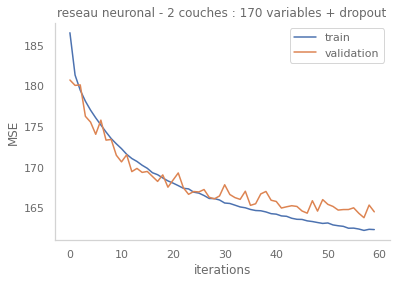

In [61]:
import matplotlib.pyplot as plt

plt.plot(history_2hl.history['mean_squared_error'])
plt.plot(history_2hl.history['val_mean_squared_error'])
plt.title('reseau neuronal - 2 couches : 170 variables + dropout')
plt.ylabel('MSE')
plt.xlabel('iterations')
plt.legend(['train' , 'validation'] , loc = 'upper right')
plt.show()

#### Scores R2 / Nombre de couche

In [57]:
y_train_tf=np.squeeze(y_train) #helps to get rid of useless one dimension arrays 
y_pred=np.squeeze(model_2hl.predict_on_batch(X_train_std))

In [73]:
y_test_tf=np.squeeze(y_test) #helps to get rid of useless one dimension arrays 
y_pred=np.squeeze(model_2hl.predict_on_batch(X_test_std))

In [112]:
# 1 couche
r2_score(y_train_tf,y_pred)

<tf.Tensor: shape=(), dtype=float64, numpy=0.38685096436635025>

In [32]:
# 1 couche + drop out
r2_score(y_train_tf,y_pred)

<tf.Tensor: shape=(), dtype=float64, numpy=0.22565555153796857>

In [67]:
# 1 couche :256 variables + drop out
r2_score(y_train_tf,y_pred)

0.22554817746446754

In [69]:
# 1 couche sur les donnees test :256 variables + drop out
r2_score(y_test_tf,y_pred)

0.18854159258788317

In [46]:
# 1 couche :170 variables + drop out
r2_score(y_train_tf,y_pred)

0.21304471525693003

In [48]:
# 1 couche sur les donnees test: 170 variables + drop out
r2_score(y_test_tf,y_pred)

0.18160278933686969

In [89]:
# 2 couches sur les donnees d'entrainement
r2_score(y_train_tf,y_pred)

<tf.Tensor: shape=(), dtype=float64, numpy=0.4202894954673908>

In [32]:
# 2 couches sur les donnees d'entrainement + data
r2_score(y_train_tf,y_pred)

<tf.Tensor: shape=(), dtype=float64, numpy=0.38493509613134425>

In [34]:
# 2 couches sur les donnees de test + data
r2_score(y_test_tf,y_pred)

<tf.Tensor: shape=(), dtype=float64, numpy=0.0743823255329168>

In [118]:
# 2 couches sur les donnees d'entrainement + dropout
r2_score(y_train_tf,y_pred)

<tf.Tensor: shape=(), dtype=float64, numpy=0.22391191844088143>

In [140]:
# 2 couches sur les donnees de test + dropout
r2_score(y_test_tf,y_pred)

<tf.Tensor: shape=(), dtype=float64, numpy=0.16893537112102186>

In [112]:
# 2 couches sur les donnees d'entrainement - 170 variables
r2_score(y_train_tf,y_pred)

<tf.Tensor: shape=(), dtype=float64, numpy=0.22146012922074765>

In [114]:
# 2 couches sur les donnees de test - 170 variables
r2_score(y_test_tf,y_pred)

<tf.Tensor: shape=(), dtype=float64, numpy=0.18819768028272466>

In [58]:
# 2 couches sur les donnees d'entrainement: 170 variables + dropout
r2_score(y_train_tf,y_pred)

0.2260177203139695

In [60]:
# 2 couches sur les donnees de test: 170 variables + dropout
r2_score(y_test_tf,y_pred)

0.1906550265265473

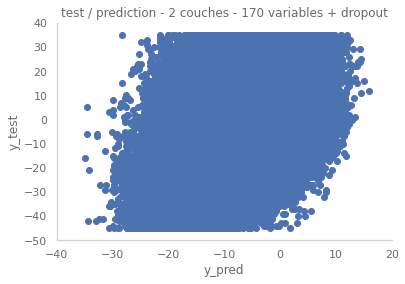

In [74]:
import matplotlib.pyplot as plt
plt.rcParams['agg.path.chunksize'] = 10000
## définir les limites des axes
plt.xlim(-40, 20)
plt.ylim(-50, 40)

plt.scatter(np.squeeze(y_pred), np.squeeze(y_test))
plt.title('test / prediction - 2 couches - 170 variables + dropout')
plt.xlabel('y_pred')
plt.ylabel('y_test')
plt.show()

Le modèle de reseau neuronal à 2 couches avec dropout présente le meilleur score R2 en entrainement et en test: => nous choisissons ce modèle pour le moteur du site.

# Moteur

In [23]:
import joblib
XColumns=X.columns
#joblib.dump(XColumns, "XColumns.jbl.bz2")
XColumns=joblib.load("XColumns.jbl.bz2")

In [65]:
inputOrigin="Oklahoma City, OK"
inputDestination="Chicago, IL"
inputCarrier="DL"
inputHeure="1757"
inputJour="06"
inputMois="1"

In [66]:
originCityColumnName="ORIGIN_CITY_NAME_"+inputOrigin
originCityColumnIndex=np.argwhere(XColumns.isin([originCityColumnName])).ravel()

destinationCityColumnName="DEST_CITY_NAME_"+inputDestination
destinationCityColumnIndex=np.argwhere(XColumns.isin([destinationCityColumnName])).ravel()

carrierColumnName="CARRIER_"+inputCarrier
carrierColumnIndex=np.argwhere(XColumns.isin([carrierColumnName])).ravel()

depTimeColumnIndex=np.argwhere(XColumns.isin(["CRS_DEP_TIME"])).ravel()
dayOfMonthColumnIndex=np.argwhere(XColumns.isin(["DAY_OF_MONTH"])).ravel()
monthColumnIndex=np.argwhere(XColumns.isin(["MONTH"])).ravel()

distanceColumnIndex=np.argwhere(XColumns.isin(["DISTANCE"])).ravel()
shortFlightColumnIndex=np.argwhere(XColumns.isin(["SHORT_FLIGHT"])).ravel()
mediumFlightIndex=np.argwhere(XColumns.isin(["MEDIUM_FLIGHT"])).ravel()
longFlightIndex=np.argwhere(XColumns.isin(["LONG_FLIGHT"])).ravel()

In [57]:
matrixFlightInfos=df[['DISTANCE','SHORT_FLIGHT','MEDIUM_FLIGHT','LONG_FLIGHT','CARRIER','ORIGIN_CITY_NAME','DEST_CITY_NAME']].drop_duplicates()
matrixFlightInfos.drop_duplicates()
matrixFlightInfos.sample(10)

,DISTANCE,SHORT_FLIGHT,MEDIUM_FLIGHT,LONG_FLIGHT,CARRIER,ORIGIN_CITY_NAME,DEST_CITY_NAME
262983,368.00,0,1,0,WN,"Las Vegas, NV","Salt Lake City, UT"
128260,667.00,0,1,0,OO,"El Paso, TX","Houston, TX"
287226,892.00,0,1,0,WN,"Fort Myers, FL","Washington, DC"
145975,758.00,0,1,0,UA,"Orlando, FL","Washington, DC"
101492,760.00,0,1,0,DL,"New York, NY","Atlanta, GA"
79822,"1,237.00",0,1,0,B6,"Boston, MA","Fort Lauderdale, FL"
2350,"2,556.00",0,1,0,AA,"Los Angeles, CA","Honolulu, HI"
241059,247.00,1,0,0,EV,"Houston, TX","Dallas/Fort Worth, TX"
146308,787.00,0,1,0,UA,"Tampa, FL","Houston, TX"
100231,"1,851.00",0,1,0,DL,"Washington, DC","Salt Lake City, UT"


In [68]:
rowFlightInfos=matrixFlightInfos.loc[(matrixFlightInfos['CARRIER']==inputCarrier) & (matrixFlightInfos['ORIGIN_CITY_NAME']==inputOrigin) & (matrixFlightInfos['DEST_CITY_NAME']==inputDestination)]
if len(rowFlightInfos)==0:
    rowFlightInfos=matrixFlightInfos.loc[(matrixFlightInfos['ORIGIN_CITY_NAME']==inputOrigin) & (matrixFlightInfos['DEST_CITY_NAME']==inputDestination)]

In [70]:
# creation de Xinput
Xinput=np.repeat(0,170).reshape(1,170)
Xinput.shape

(1, 170)

In [71]:
# mise à jour de Xinput
Xinput[0,distanceColumnIndex]=float(rowFlightInfos['DISTANCE'].iloc[0])
Xinput[0,shortFlightColumnIndex]=rowFlightInfos['SHORT_FLIGHT'].iloc[0]
Xinput[0,mediumFlightIndex]=rowFlightInfos['MEDIUM_FLIGHT'].iloc[0]
Xinput[0,longFlightIndex]=rowFlightInfos['LONG_FLIGHT'].iloc[0]
Xinput[0,originCityColumnIndex]=1
Xinput[0,destinationCityColumnIndex]=1
Xinput[0,carrierColumnIndex]=1
Xinput[0,depTimeColumnIndex]=float(inputHeure)
Xinput[0,dayOfMonthColumnIndex]=float(inputJour)
Xinput[0,monthColumnIndex]=float(inputMois)

In [72]:
# standardiser les données (centré reduit)
from sklearn import preprocessing
robust_scale=preprocessing.RobustScaler().fit(X_train) # moins sensible aux valeurs aberrantes
#joblib.dump(robust_scale,"robust_scale.jbl.bz2")
#X_train_std = std_scale.transform(X_train)
Xinput_std = robust_scale.transform(Xinput)

In [73]:
#y_train_tf=np.squeeze(y_train.iloc[1234]) #helps to get rid of useless one dimension arrays 
y_pred=np.squeeze(model_2hl.predict_on_batch(Xinput_std))
y_pred

array(-12.956739, dtype=float32)

In [128]:
# matrice d'affichage des données d'origine (pour comparaison avec les predictions)
matrix_ARR_DELAY=df[['ARR_DELAY','CRS_DEP_TIME','DAY_OF_MONTH','MONTH','DISTANCE','SHORT_FLIGHT','MEDIUM_FLIGHT','LONG_FLIGHT','CARRIER','ORIGIN_CITY_NAME','DEST_CITY_NAME']].drop_duplicates()
matrix_ARR_DELAY.drop_duplicates()
matrix_ARR_DELAY.sample(20)

,ARR_DELAY,CRS_DEP_TIME,DAY_OF_MONTH,MONTH,DISTANCE,SHORT_FLIGHT,MEDIUM_FLIGHT,LONG_FLIGHT,CARRIER,ORIGIN_CITY_NAME,DEST_CITY_NAME
379698,-2.00,"1,425.00",23,2,983.00,0,1,0,NK,"Tampa, FL","Detroit, MI"
840659,13.00,740.00,15,3,"1,626.00",0,1,0,WN,"Dallas, TX","Portland, OR"
664509,-5.00,"1,300.00",16,2,562.00,0,1,0,WN,"El Paso, TX","Dallas, TX"
972723,-11.00,"1,015.00",7,3,472.00,0,1,0,UA,"Denver, CO","Omaha, NE"
270683,-11.00,"1,425.00",3,1,"1,047.00",0,1,0,WN,"St. Louis, MO","Boston, MA"
751577,-15.00,"1,945.00",24,3,680.00,0,1,0,DL,"Minneapolis, MN","Denver, CO"
451519,-5.00,"1,330.00",22,2,852.00,0,1,0,AA,"Minneapolis, MN","Dallas/Fort Worth, TX"
794205,-5.00,"1,425.00",1,3,189.00,1,0,0,WN,"Dallas, TX","Austin, TX"
433805,-18.00,"1,755.00",3,2,"1,222.00",0,1,0,UA,"Houston, TX","Las Vegas, NV"
213320,7.00,930.00,19,1,270.00,1,0,0,DL,"Atlanta, GA","Jacksonville, FL"


In [106]:
import joblib
#joblib.dump(matrix_ARR_DELAY,"matrix_ARR_DELAY.jbl.bz2")
matrix_ARR_DELAY=joblib.load("matrix_ARR_DELAY.jbl.bz2")

In [191]:
inputOrigin="Oklahoma City, OK"
inputDestination="Chicago, IL"
inputCarrier="EV"
inputHeure="1757"
inputJour="6"
inputMois="1"
matrix_ARR_DELAY.loc[(matrix_ARR_DELAY['CARRIER']==inputCarrier) & 
                     (matrix_ARR_DELAY['ORIGIN_CITY_NAME']==inputOrigin) &
                     (matrix_ARR_DELAY['DEST_CITY_NAME']==inputDestination) &
                     (matrix_ARR_DELAY['CRS_DEP_TIME']==float(inputHeure)) &
                     (matrix_ARR_DELAY['DAY_OF_MONTH']==int(inputJour)) &
                     (matrix_ARR_DELAY['MONTH']==int(inputMois))
                    ]

,ARR_DELAY,CRS_DEP_TIME,DAY_OF_MONTH,MONTH,DISTANCE,SHORT_FLIGHT,MEDIUM_FLIGHT,LONG_FLIGHT,CARRIER,ORIGIN_CITY_NAME,DEST_CITY_NAME
245765,-23.00,"1,757.00",6,1,693.00,0,1,0,EV,"Oklahoma City, OK","Chicago, IL"


In [42]:
end=time.time()
print(f"elapsed: {end-start}")

elapsed: 6176.313421010971
